In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from scipy.spatial.distance import cdist
from scipy.stats.mstats import gmean

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<br>

## $\textrm{Data}$

<br>

$ \textbf{HWCDW} \ \textrm{Nominal compensation per employee: total economy (HWCDW) - 1000CU }$

$ \textbf{NLTN} \ \textrm{Total labour force (Labour force statistics) (NLTN) - 1000 persons }$

$ \textbf{OKND} \ \textrm{Net capital stock at 2010 prices: total economy (OKND) - Mrd CU }$

$ \textbf{OVGD} \ \textrm{Gross domestic product at 2010 reference levels (OVGD) - Mrd CU }$

$ \textbf{UVGE} \ \textrm{Gross value added at current basic prices excluding FISIM: total economy (UVGE) - Mrd CU }$

$ \textbf{ZUTN} \ \textrm{Unemployment rate: total :- Member States: definition EUROSTAT (ZUTN) - (Percentage of active population)  }$

$ \textbf{USGN} \ \textrm{Gross national saving (USGN) - Mrd CU  }$

<br>

In [3]:
def data_handling(data_source, study_countries):
    study_indicators = list(set(data_source.Indicator))
    study_years = [i for i in range(1997, 2020)]
    
    counter = 0
    col = ["country", "year"]; col.extend(study_indicators)
    output = pd.DataFrame(index=col)
        
    for country in study_countries:
        for year in study_years:
            counter += 1
            indicators = [data_source[(data_source.Country == country) & (data_source.Indicator == indicator)][str(year)].values[0] for indicator in study_indicators]
            row_values = [country, int(year)]; row_values.extend(indicators)
            output[counter] = row_values
    
    output_corrected = output.transpose().copy()
    output_corrected.HWCDW *= 1000
    output_corrected.NLTN *= 1000
    output_corrected.OKND *= 10**9
    output_corrected.OVGD *= 10**9
    output_corrected.UVGE *= 10**9
    output_corrected.ZUTN /= 100
    output_corrected.USGN *= 10**9
    
    OVGD = pd.DataFrame(index=list(range(1997,2020)))
    for country in study_countries:
        OVGD[country] = output_corrected[(output_corrected.country == country) & (output_corrected.year >= 1997)].OVGD.values
    OVGD.index = pd.to_datetime(OVGD.index, format='%Y')
    
    return(output_corrected, OVGD)

In [4]:
study_countries = ["Austria", "Belgium", "Cyprus", "Estonia", "Finland", "France", "Germany", 
                   "Greece", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", 
                   "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"]

In [5]:
source = pd.read_csv("./data_source.csv")
data, OVGD = data_handling(source, study_countries)

<br>

## $\textrm{Statistical}$

In [6]:
def statistical(data_input, study_countries):
    data_input=data_input[data_input.year >= 1997]
    
    study_years = [i for i in range(1997, 2020)]
    
    potential = pd.DataFrame(index=study_years)
    gap = potential.copy()
    
    for country in study_countries:
        country_series = data_input[data_input.country == country].OVGD.values
        cycle, trend = sm.tsa.filters.hpfilter(country_series, 6.25)
        
        potential[country] = trend
        gap[country] = cycle/trend
    
    potential = potential.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
    gap = gap.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
            
    return(potential, gap*100)

In [7]:
statistical_potential, statistical_gap = statistical(data, study_countries)

<br>

In [8]:
def graphs_potential(input_potential, input_gap, input_type):
      
    plt.figure()
    (input_potential/input_potential.iloc[0]*100).plot(figsize=(20, 10), colormap="tab20")
    plt.title(r"$Y^{\star}$, Eurozone ("+input_type+")", fontsize=22)
    plt.ylabel(r"$Y^{\star}$")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.figure()
    input_gap.plot(figsize=(20, 10), colormap="tab20")
    plt.title("Output Gaps, Eurozone ("+input_type+")", fontsize=22)
    plt.ylabel("Output Gap, \%")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

<Figure size 432x288 with 0 Axes>

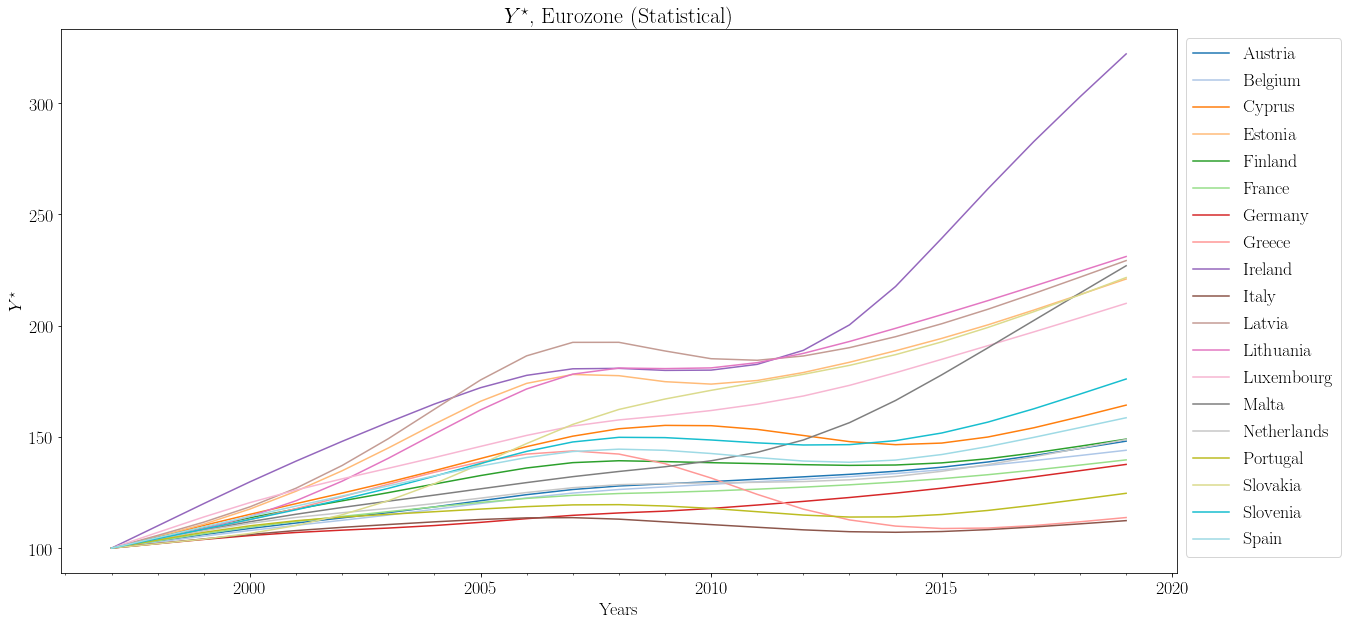

<Figure size 432x288 with 0 Axes>

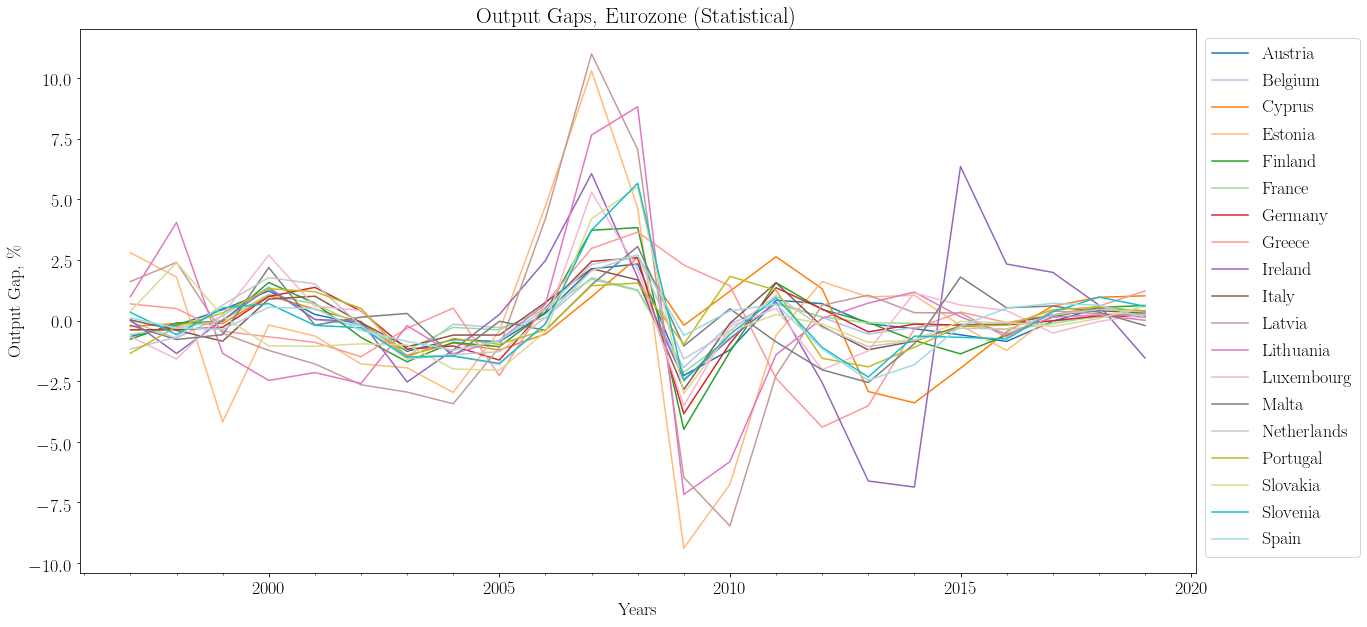

In [9]:
graphs_potential(statistical_potential, statistical_gap, "Statistical");

<br>

## $\textrm{Structural}$

In [10]:
def structural(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    data_input=data_input[data_input.year >= 1997]
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.set_index("year")

        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        
        # Calculate natural rate of unemployment
        _, country_indicators["NRU"] = sm.tsa.filters.hpfilter(country_indicators["ZUTN"].values, 6.25)
        
        # Calculate trend and gap
        output_trend[country] = country_indicators["TFP"]*(country_indicators["OKND"].pow(country_indicators["α"])*
                                                           (country_indicators["NLTN"]*(-country_indicators["NRU"]+1)).pow(-country_indicators["α"]+1))
        
        output_cycle[country] = (country_indicators["OVGD"]-output_trend[country])/output_trend[country]
        
    potential = output_trend.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
    gap = output_cycle.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
    
    return(potential, gap*100)

In [11]:
structural_potential, structural_gap = structural(data, study_countries)

<br>

<Figure size 432x288 with 0 Axes>

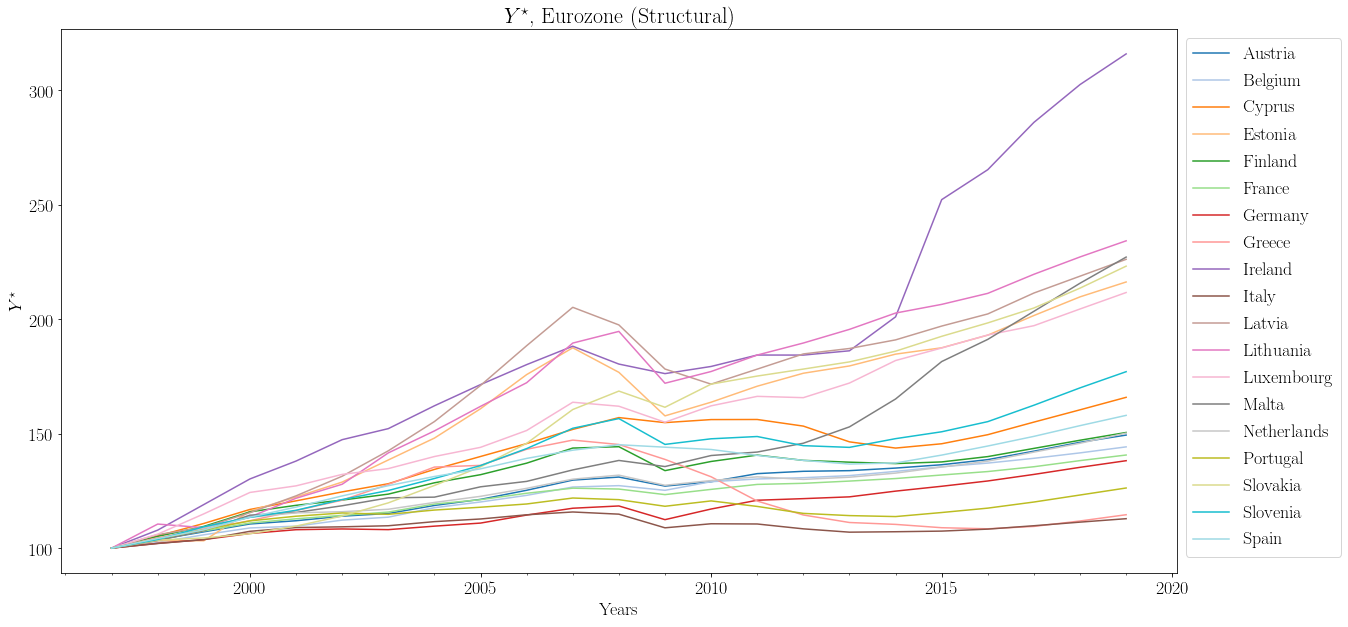

<Figure size 432x288 with 0 Axes>

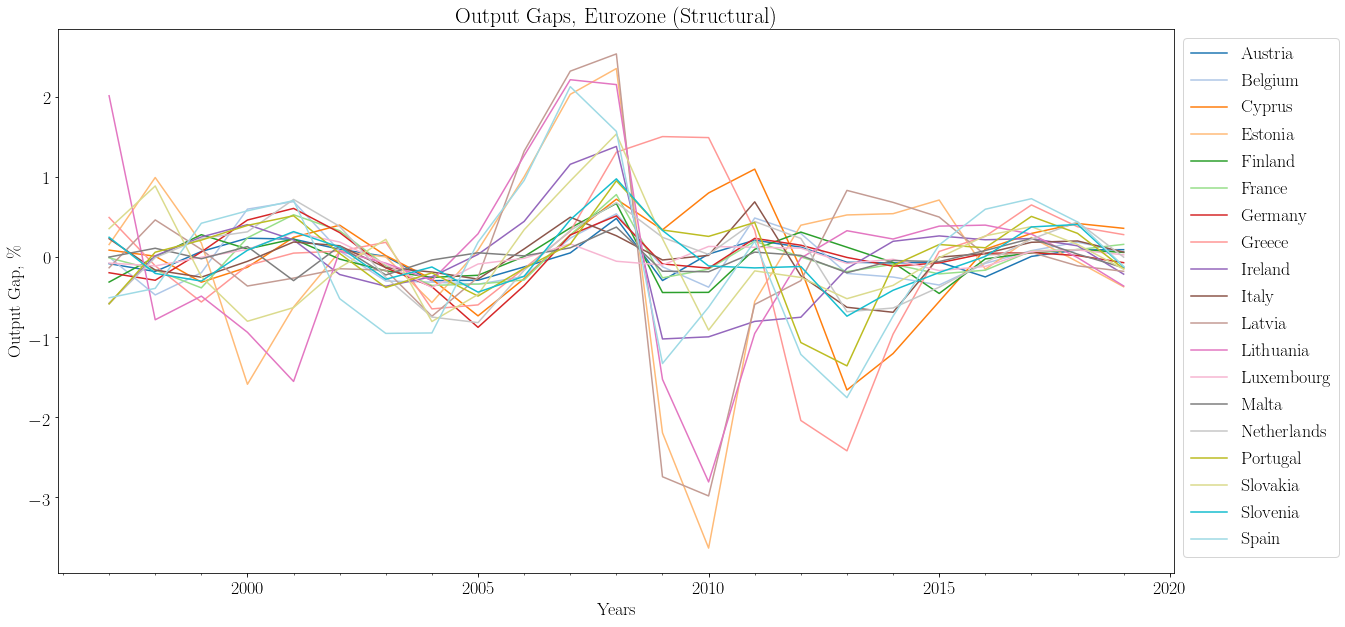

In [12]:
graphs_potential(structural_potential, structural_gap, "Structural")

<br>

In [13]:
def sd_methods(stat_gap, stru_gap):
    
    dff_temp = pd.DataFrame(index=range(1997,2020))
    dff_temp["stat"] = stat_gap.std(axis=1).values; dff_temp["stru"] = stru_gap.std(axis=1).values
    
    f, ax = plt.subplots()
    dff_temp.plot(style=['--',':'], figsize=(20, 10), color="black", ax=ax)
    ax.legend(labels=["Structural", "Statistical"])
    ax.set_title("Standard Deviation of Output Gaps, Eurozone ", fontsize=22)
    ax.set_ylabel("Standard Deviation")
    ax.set_xlabel("Year")


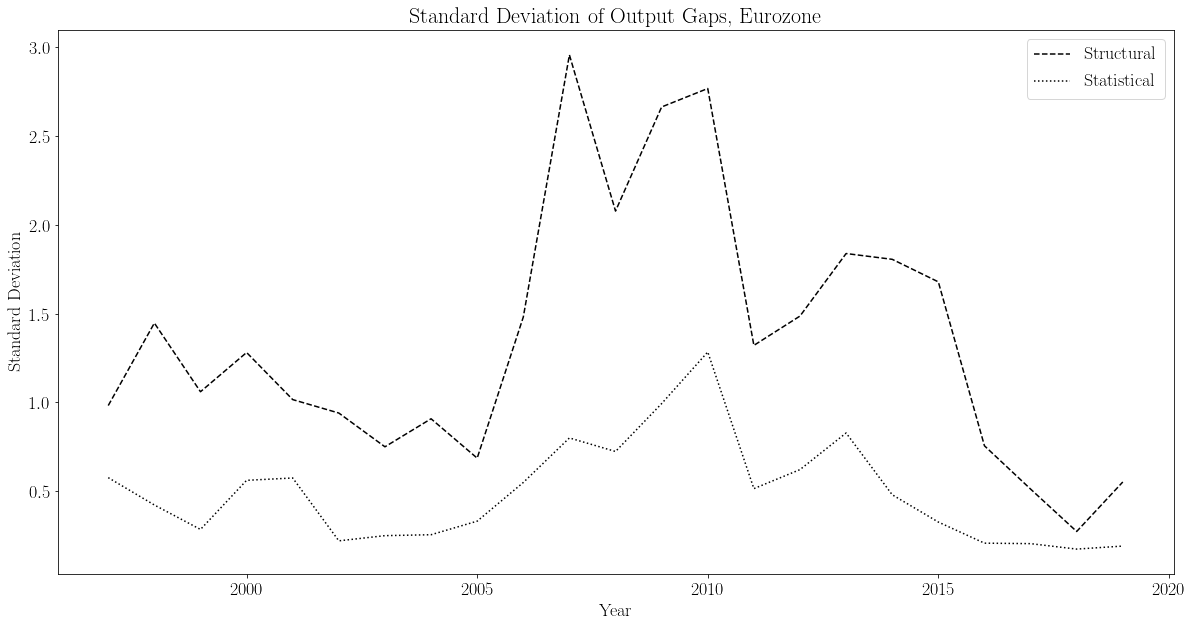

In [14]:
sd_methods(statistical_gap, structural_gap)

In [15]:
def box_methods(in_gap, text):
    
    input_gap = in_gap.copy()
    input_gap.index = range(1997,2020)
    
    f, ax = plt.subplots(figsize=(20, 10))
    input_gap.T.boxplot(ax=ax)
    ax.set_title("Boxplot of Output Gaps, Eurozone ("+text+")", fontsize=22)
    ax.set_ylabel("Standard Deviation")
    ax.set_xlabel("Year")


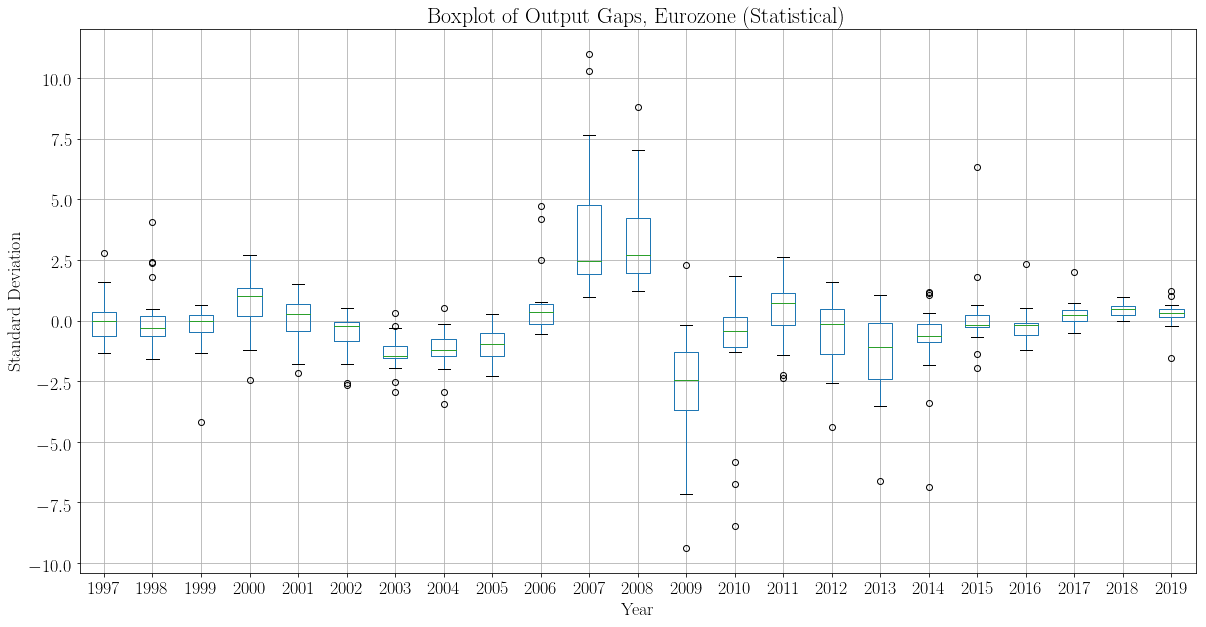

In [16]:
box_methods(statistical_gap, "Statistical")

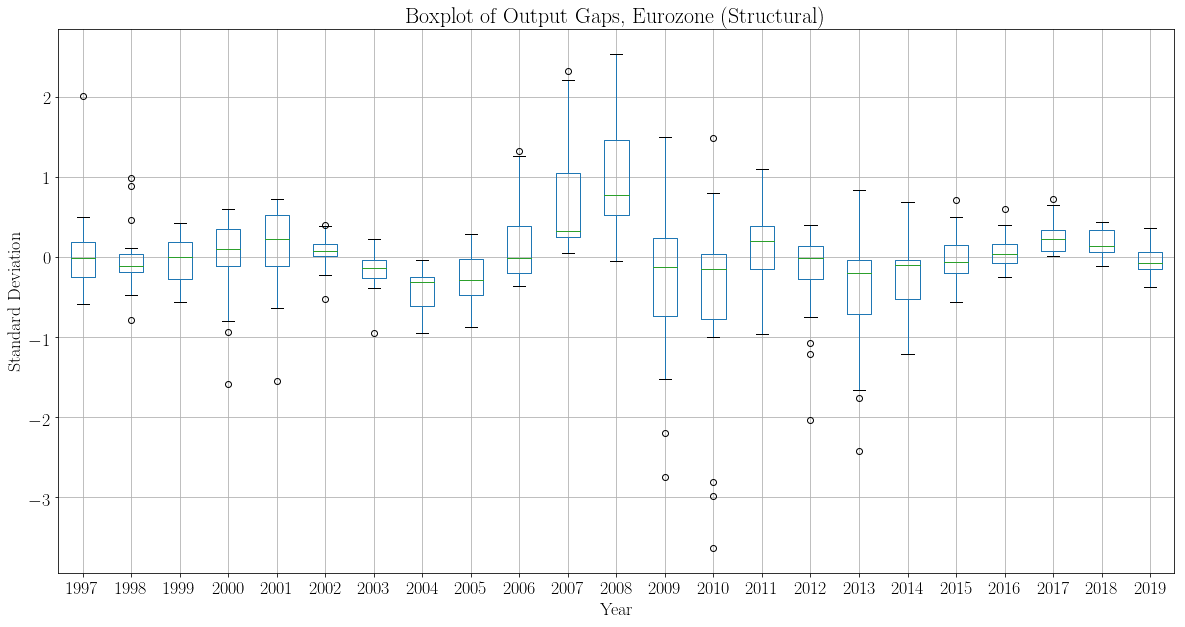

In [17]:
box_methods(structural_gap, "Structural")

<br>

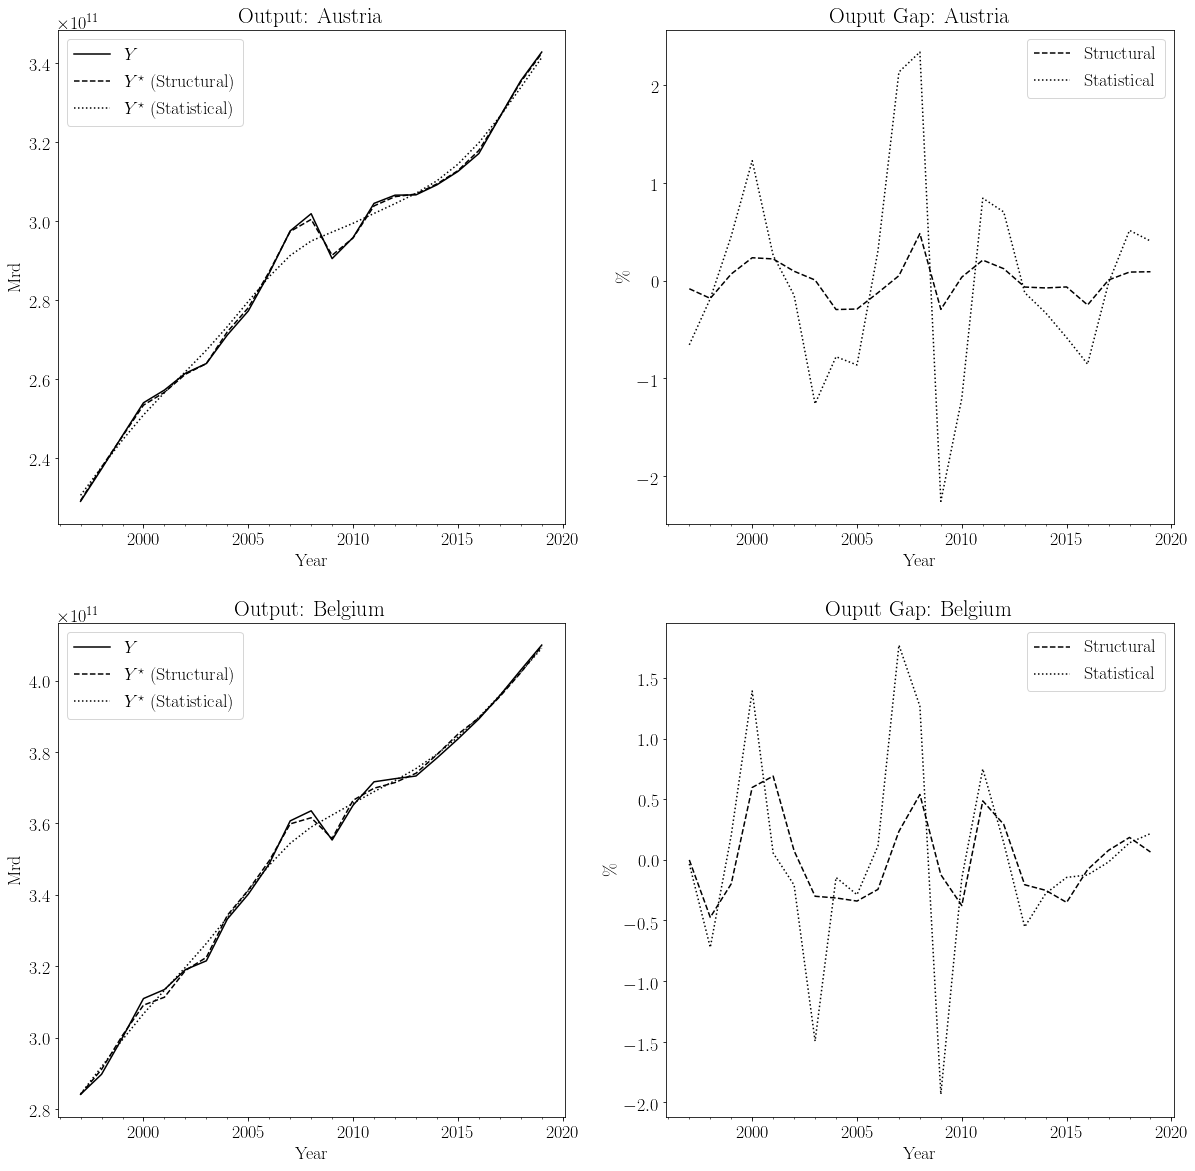

In [18]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(0,2)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

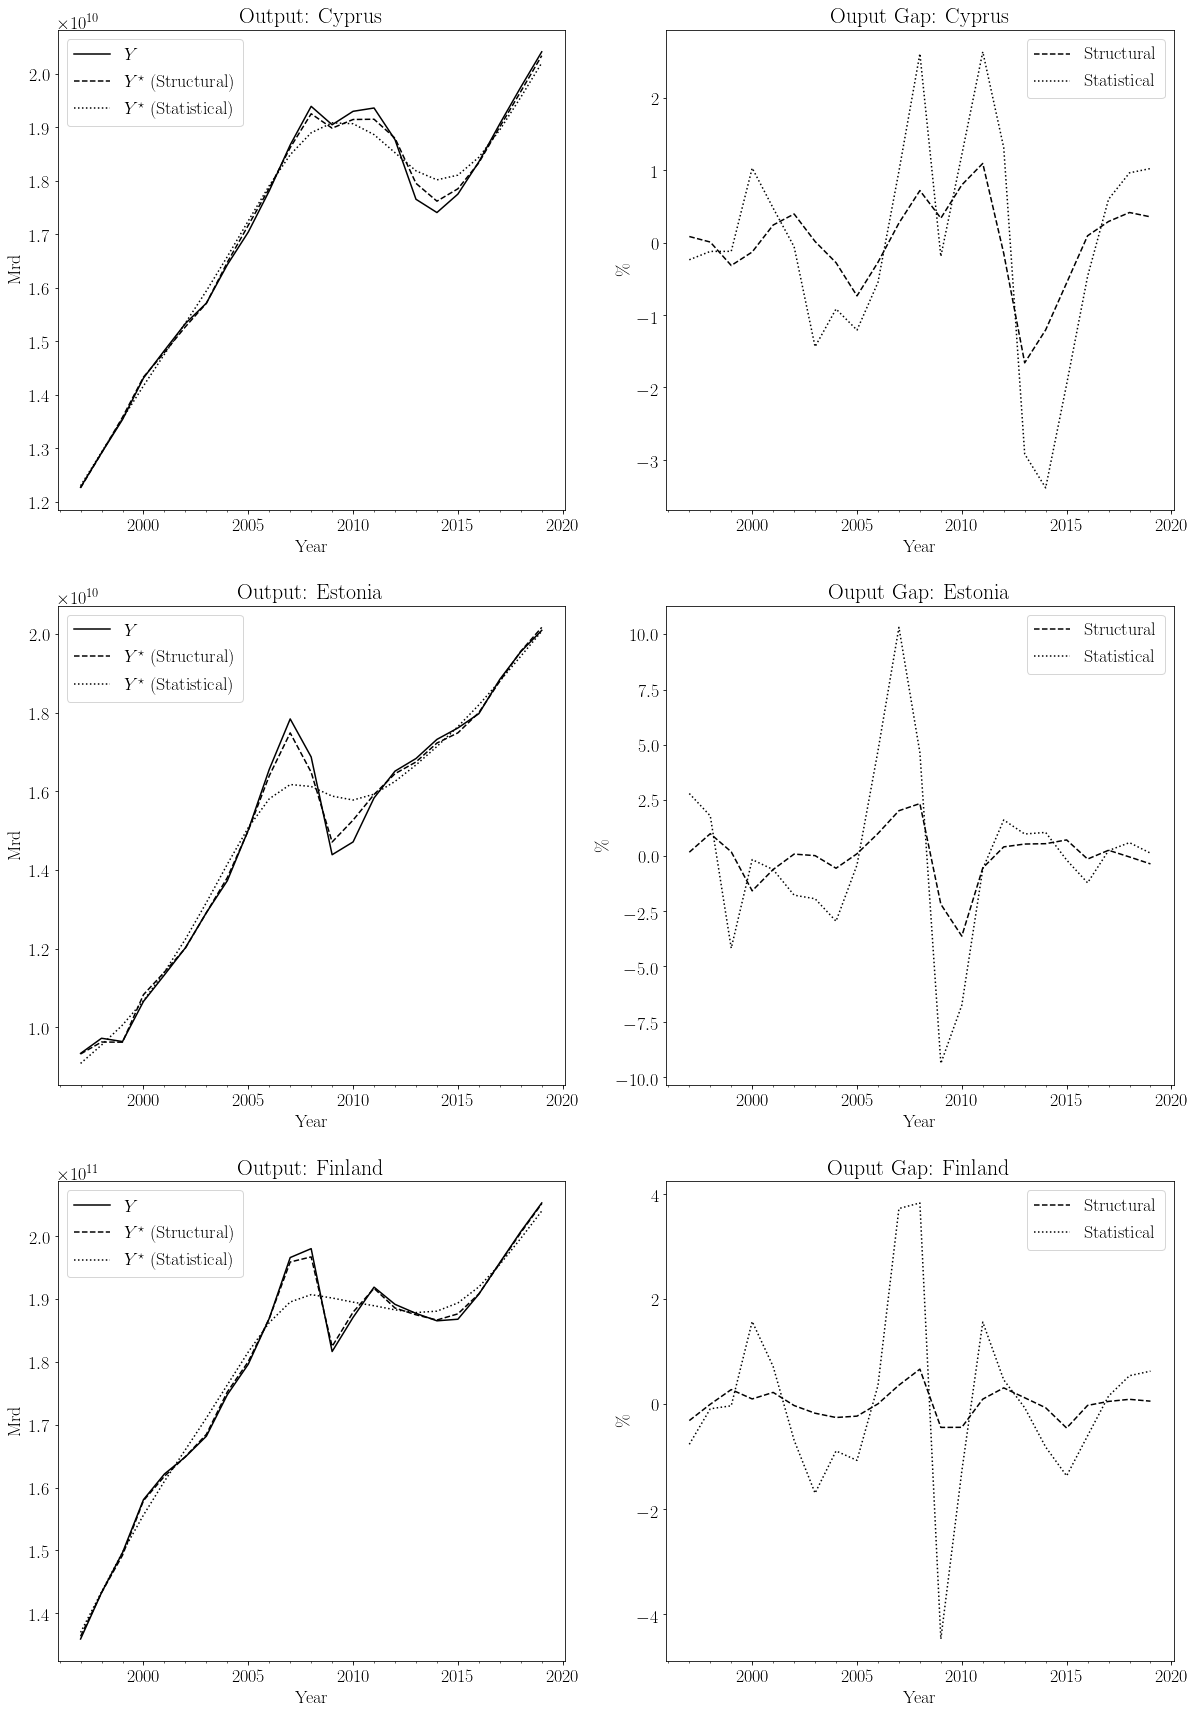

In [19]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(2,5)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

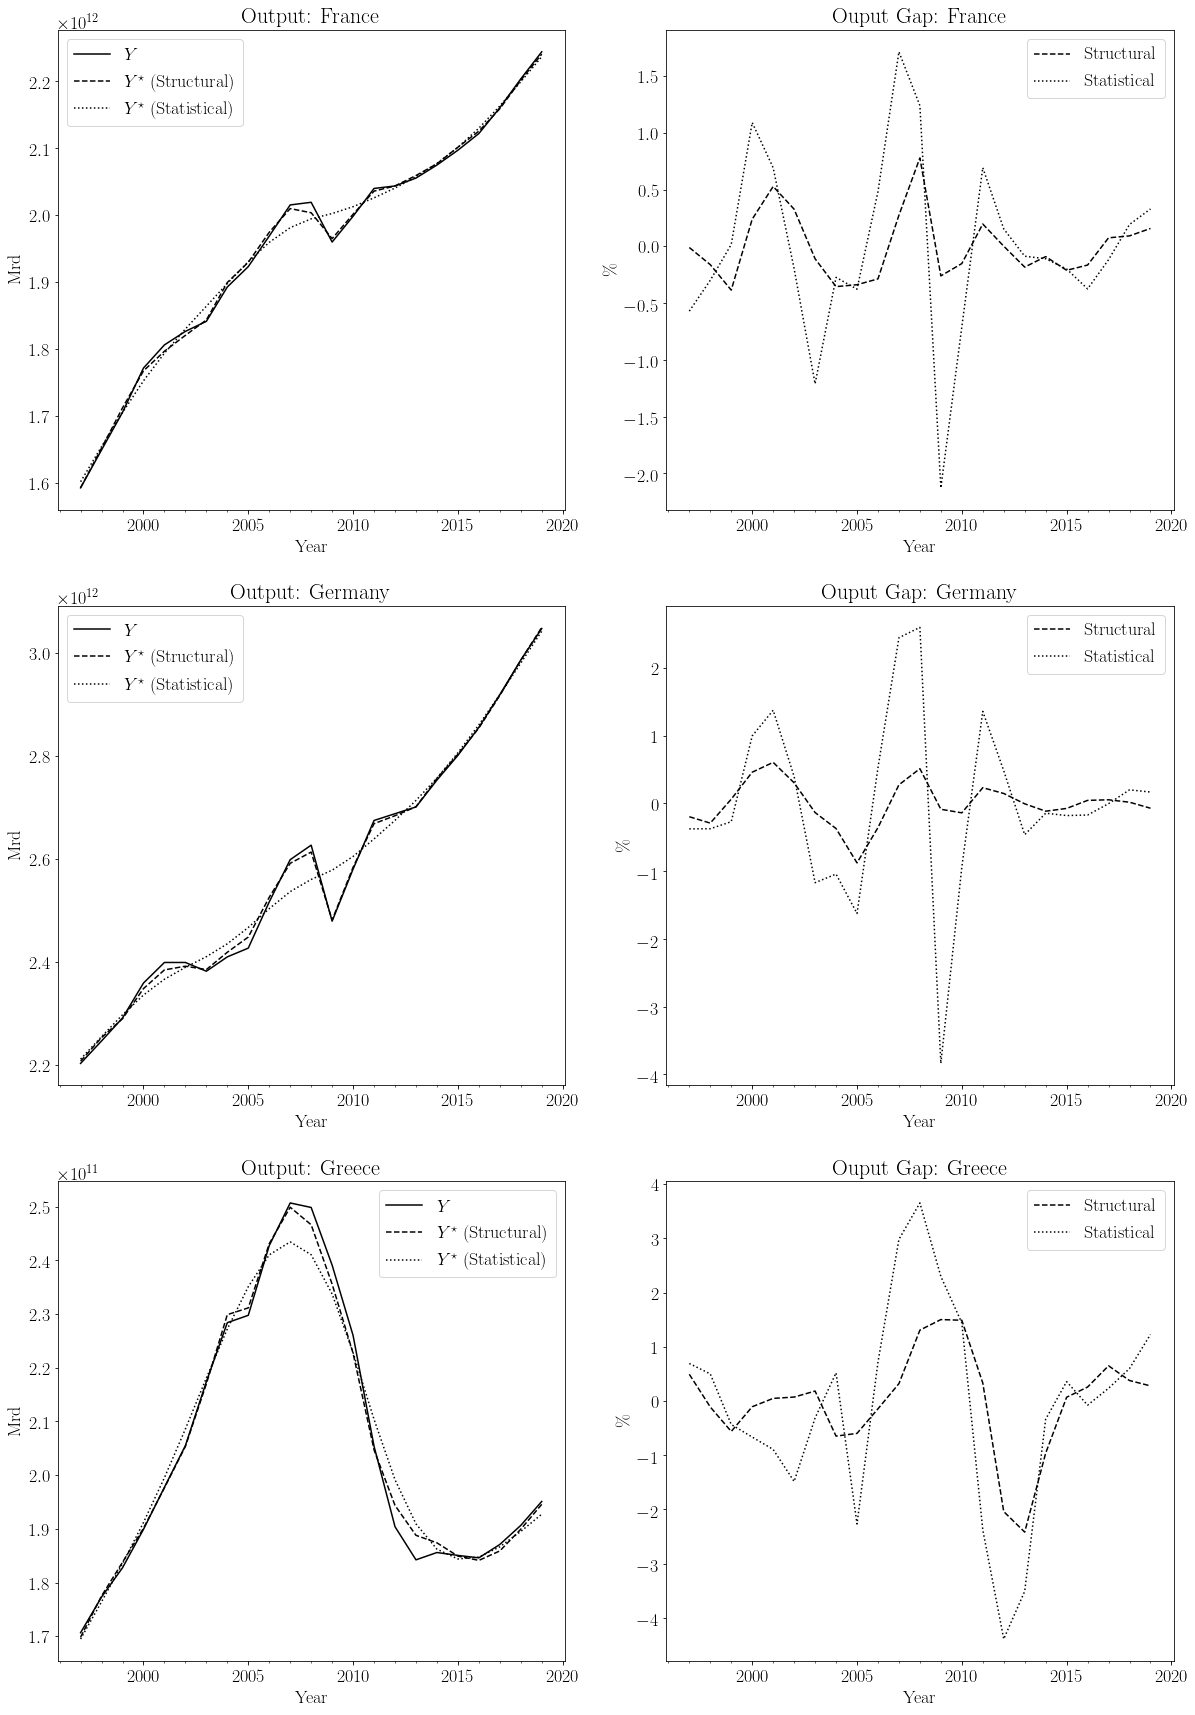

In [20]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(5,8)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

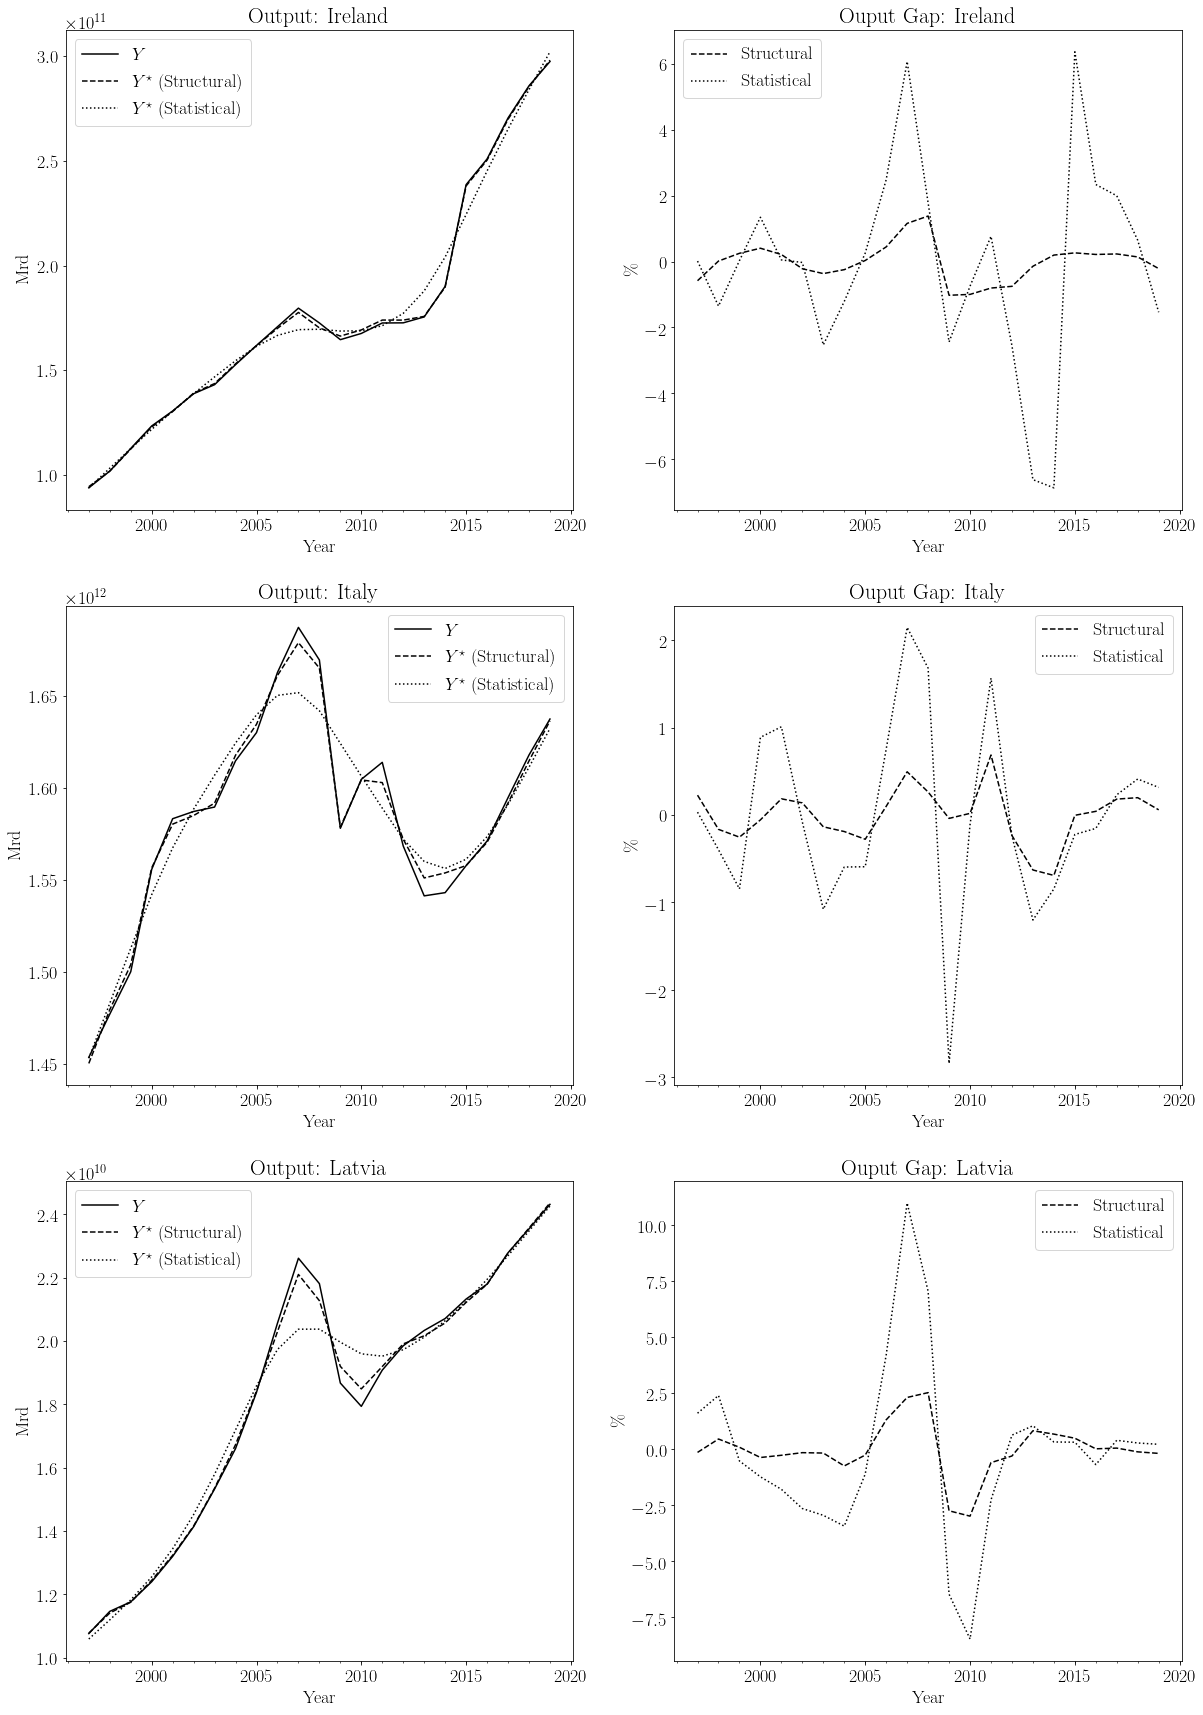

In [21]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(8,11)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

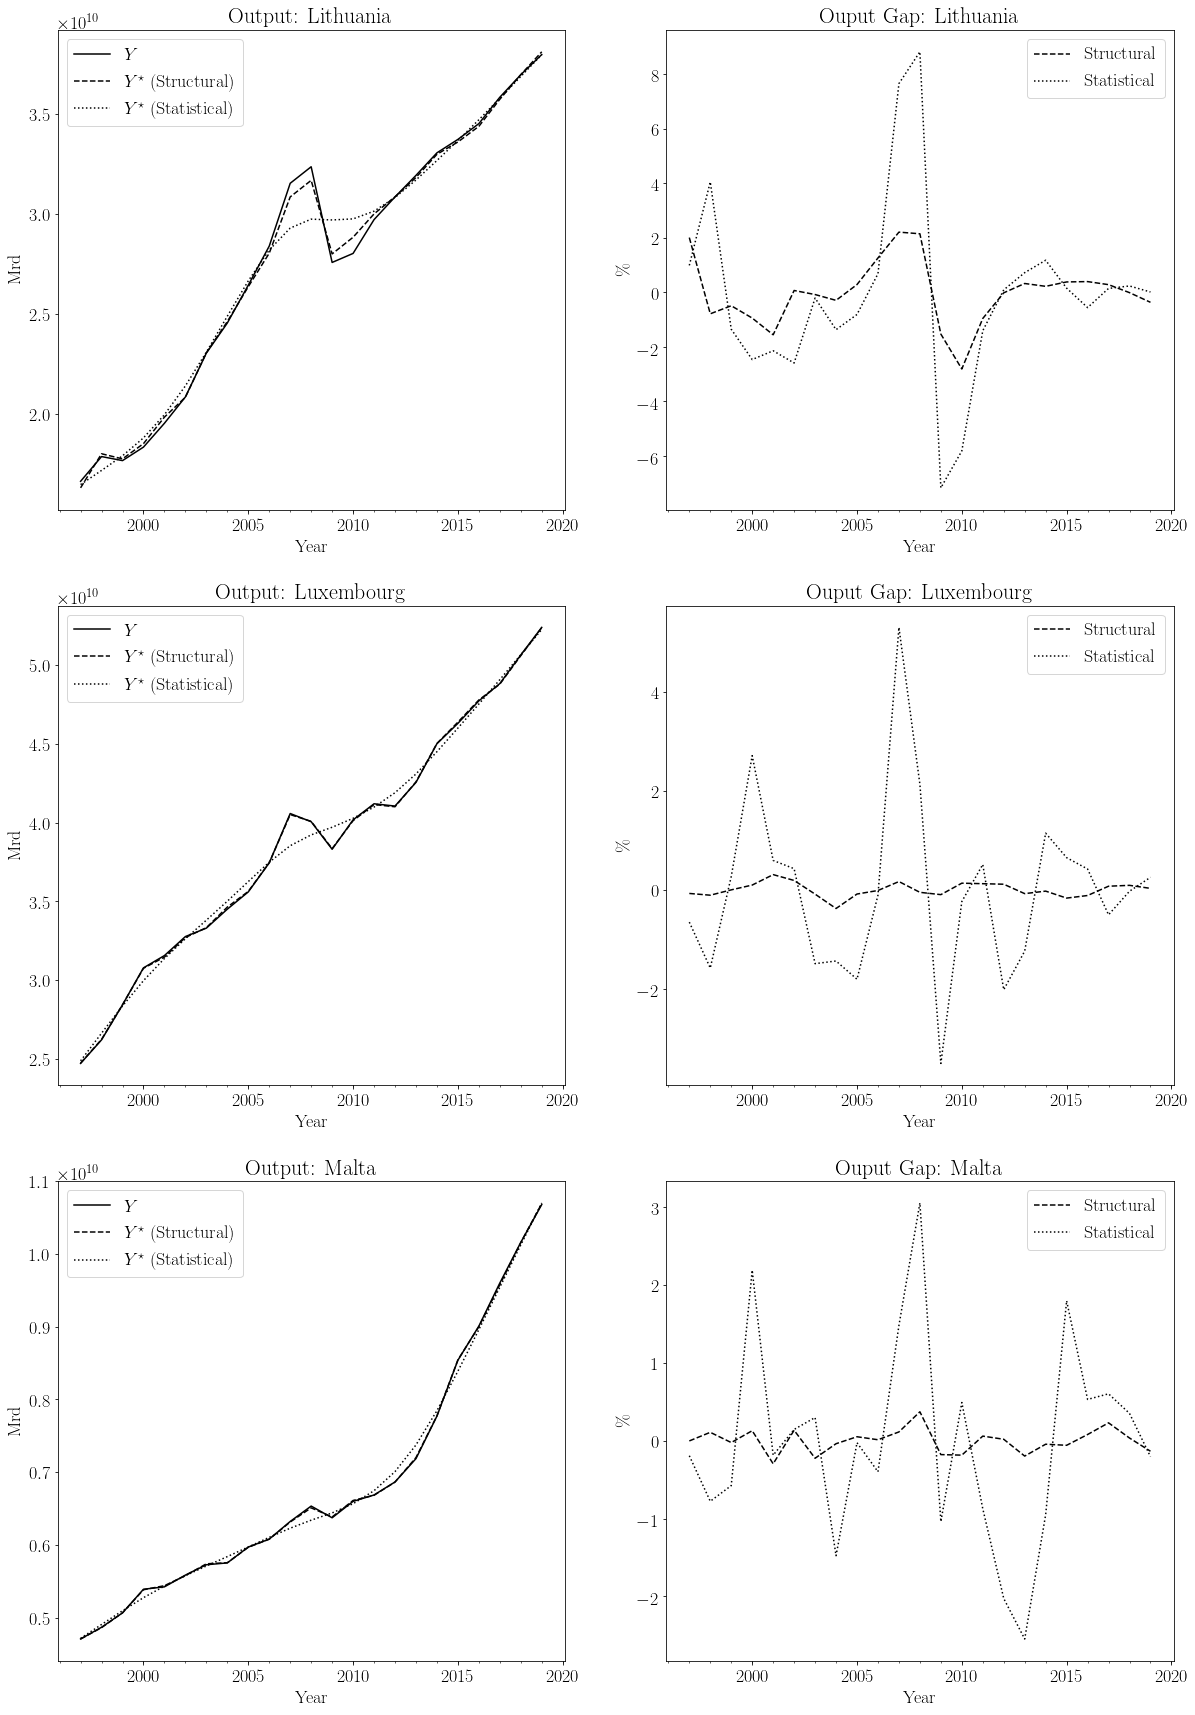

In [22]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(11,14)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

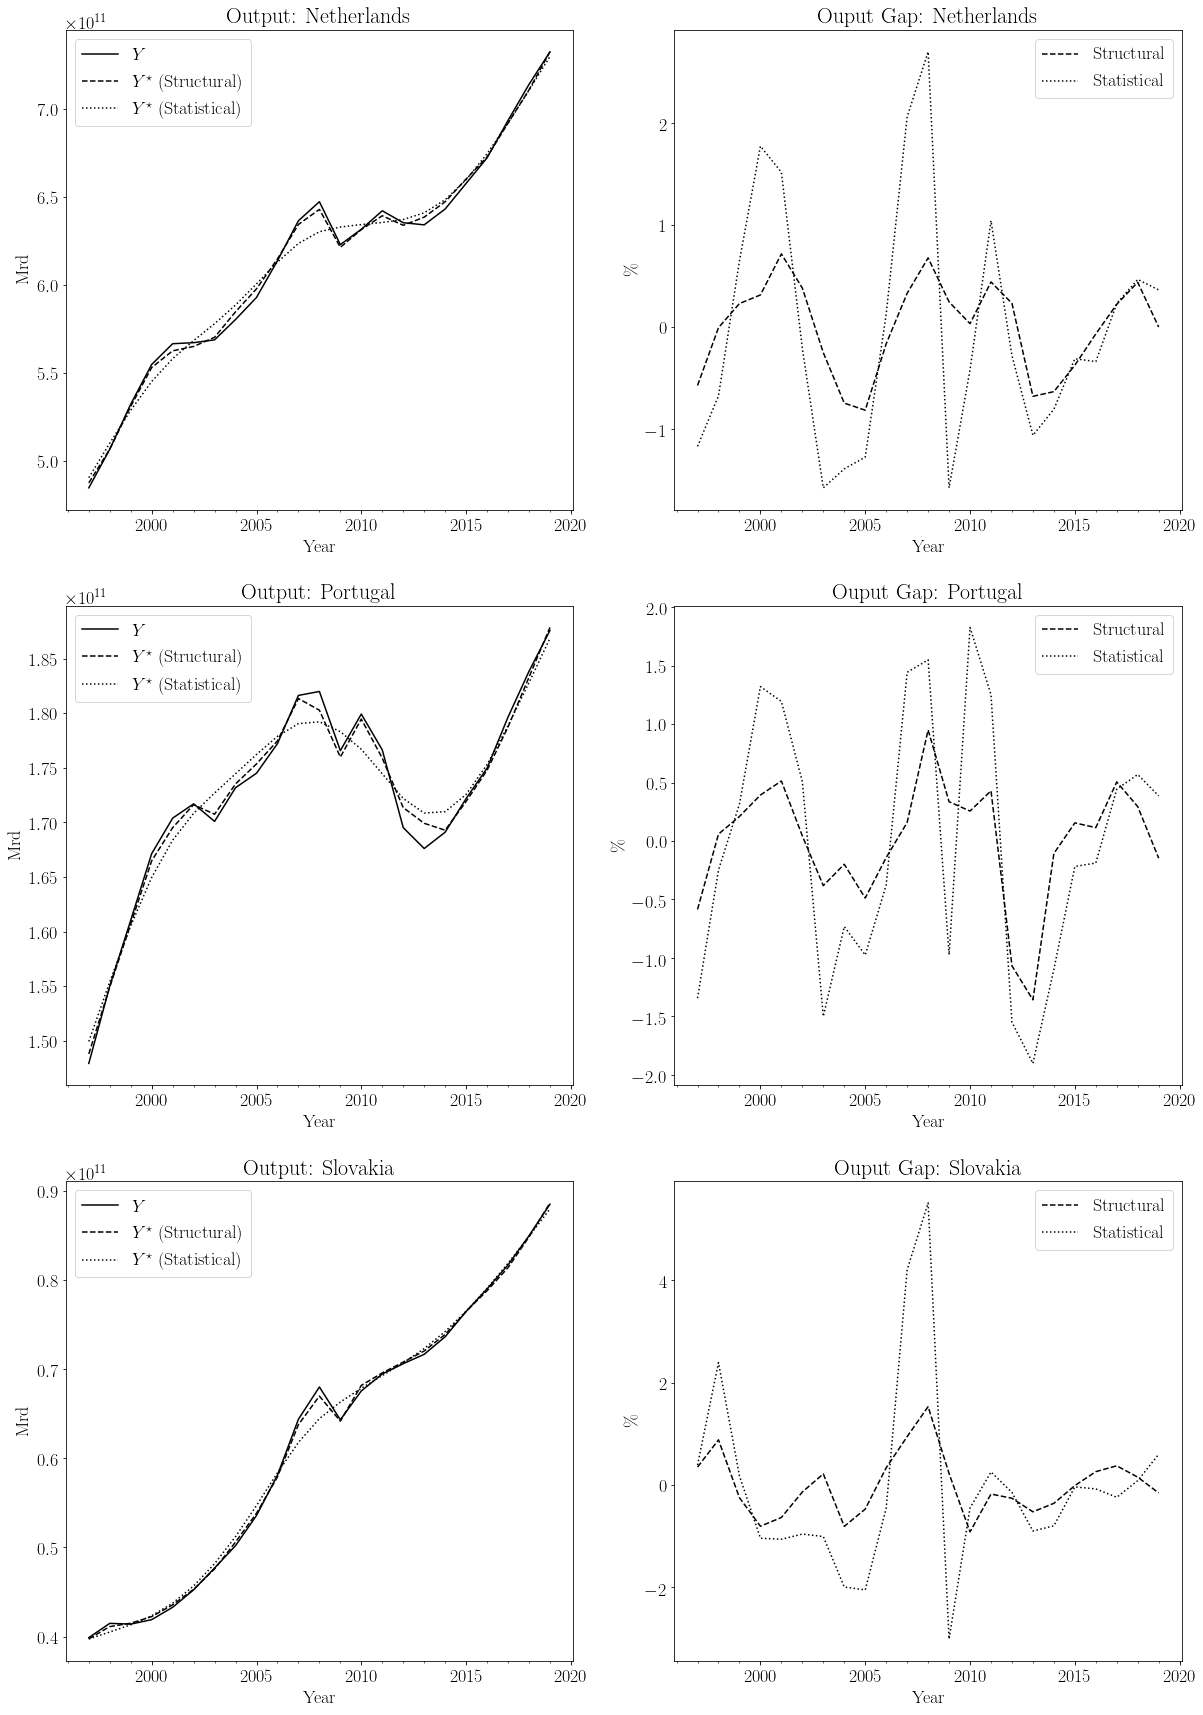

In [23]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(14,17)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

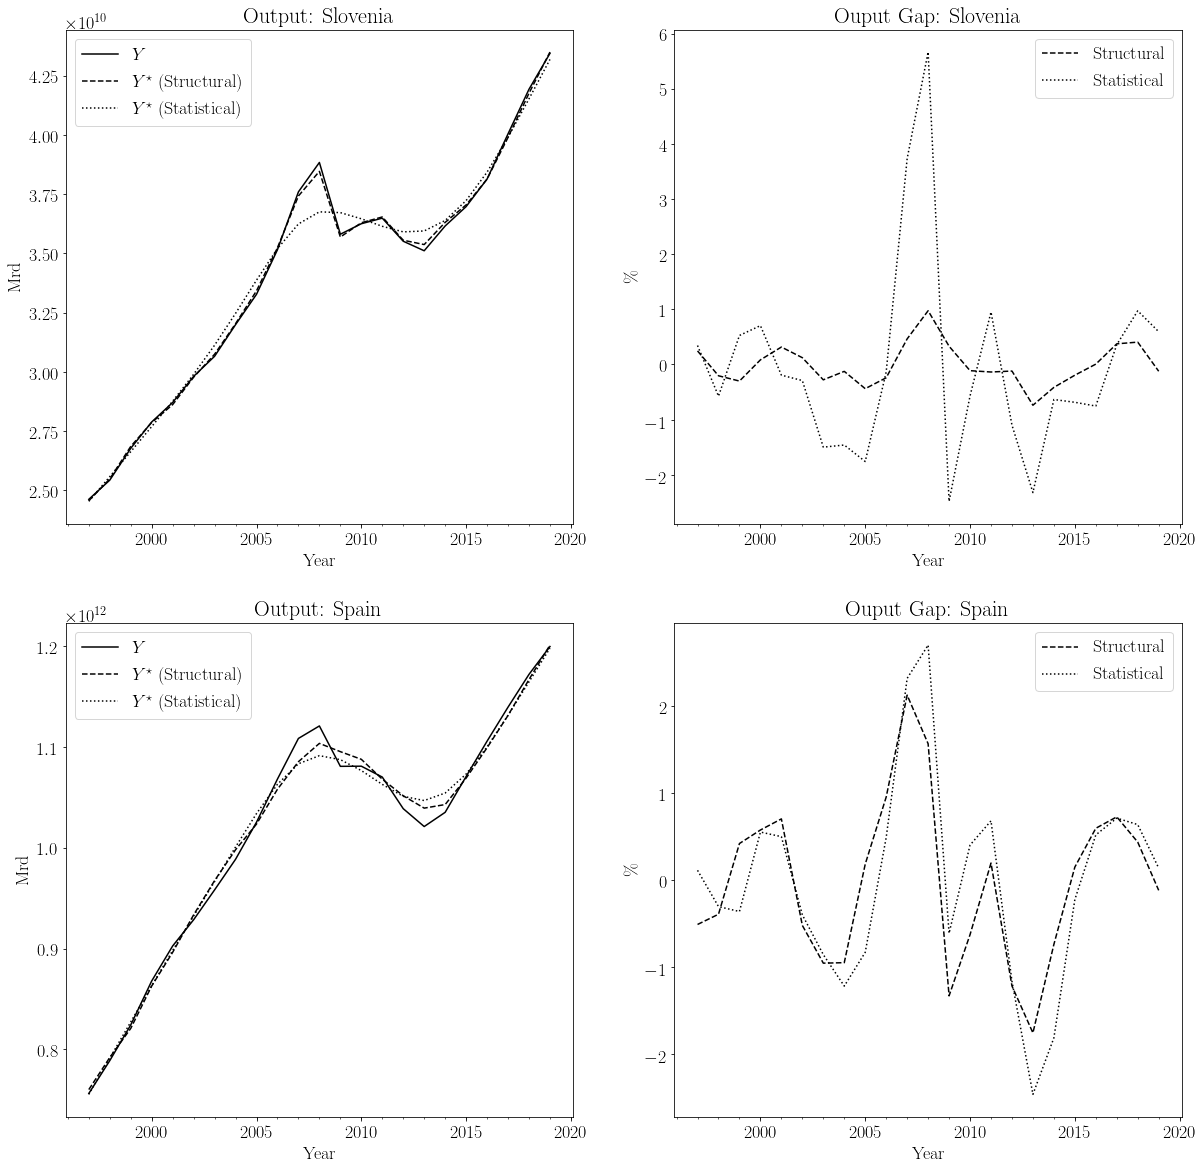

In [24]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20)); axes = axes.flatten()#; f.delaxes(axes[38]); f.delaxes(axes[39]); 
counter = 0
for i, country in enumerate(study_countries):
    if i in list(range(17,19)):
        df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
        df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
        df_temp1.plot(style=['-','--',':'], color="black", ax=axes[counter*2])
        axes[counter*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
        axes[counter*2].set_title("Output: "+country, fontsize=22)
        axes[counter*2].set_ylabel("Mrd")
        axes[counter*2].set_xlabel("Year")
    
        df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
        df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
        df_temp2.plot(style=['--',':'], color="black", ax=axes[counter*2+1])
        axes[counter*2+1].legend(labels=["Structural", "Statistical"])
        axes[counter*2+1].set_title("Ouput Gap: "+country, fontsize=22)
        axes[counter*2+1].set_ylabel("\%")
        axes[counter*2+1].set_xlabel("Year") 
        
        counter += 1

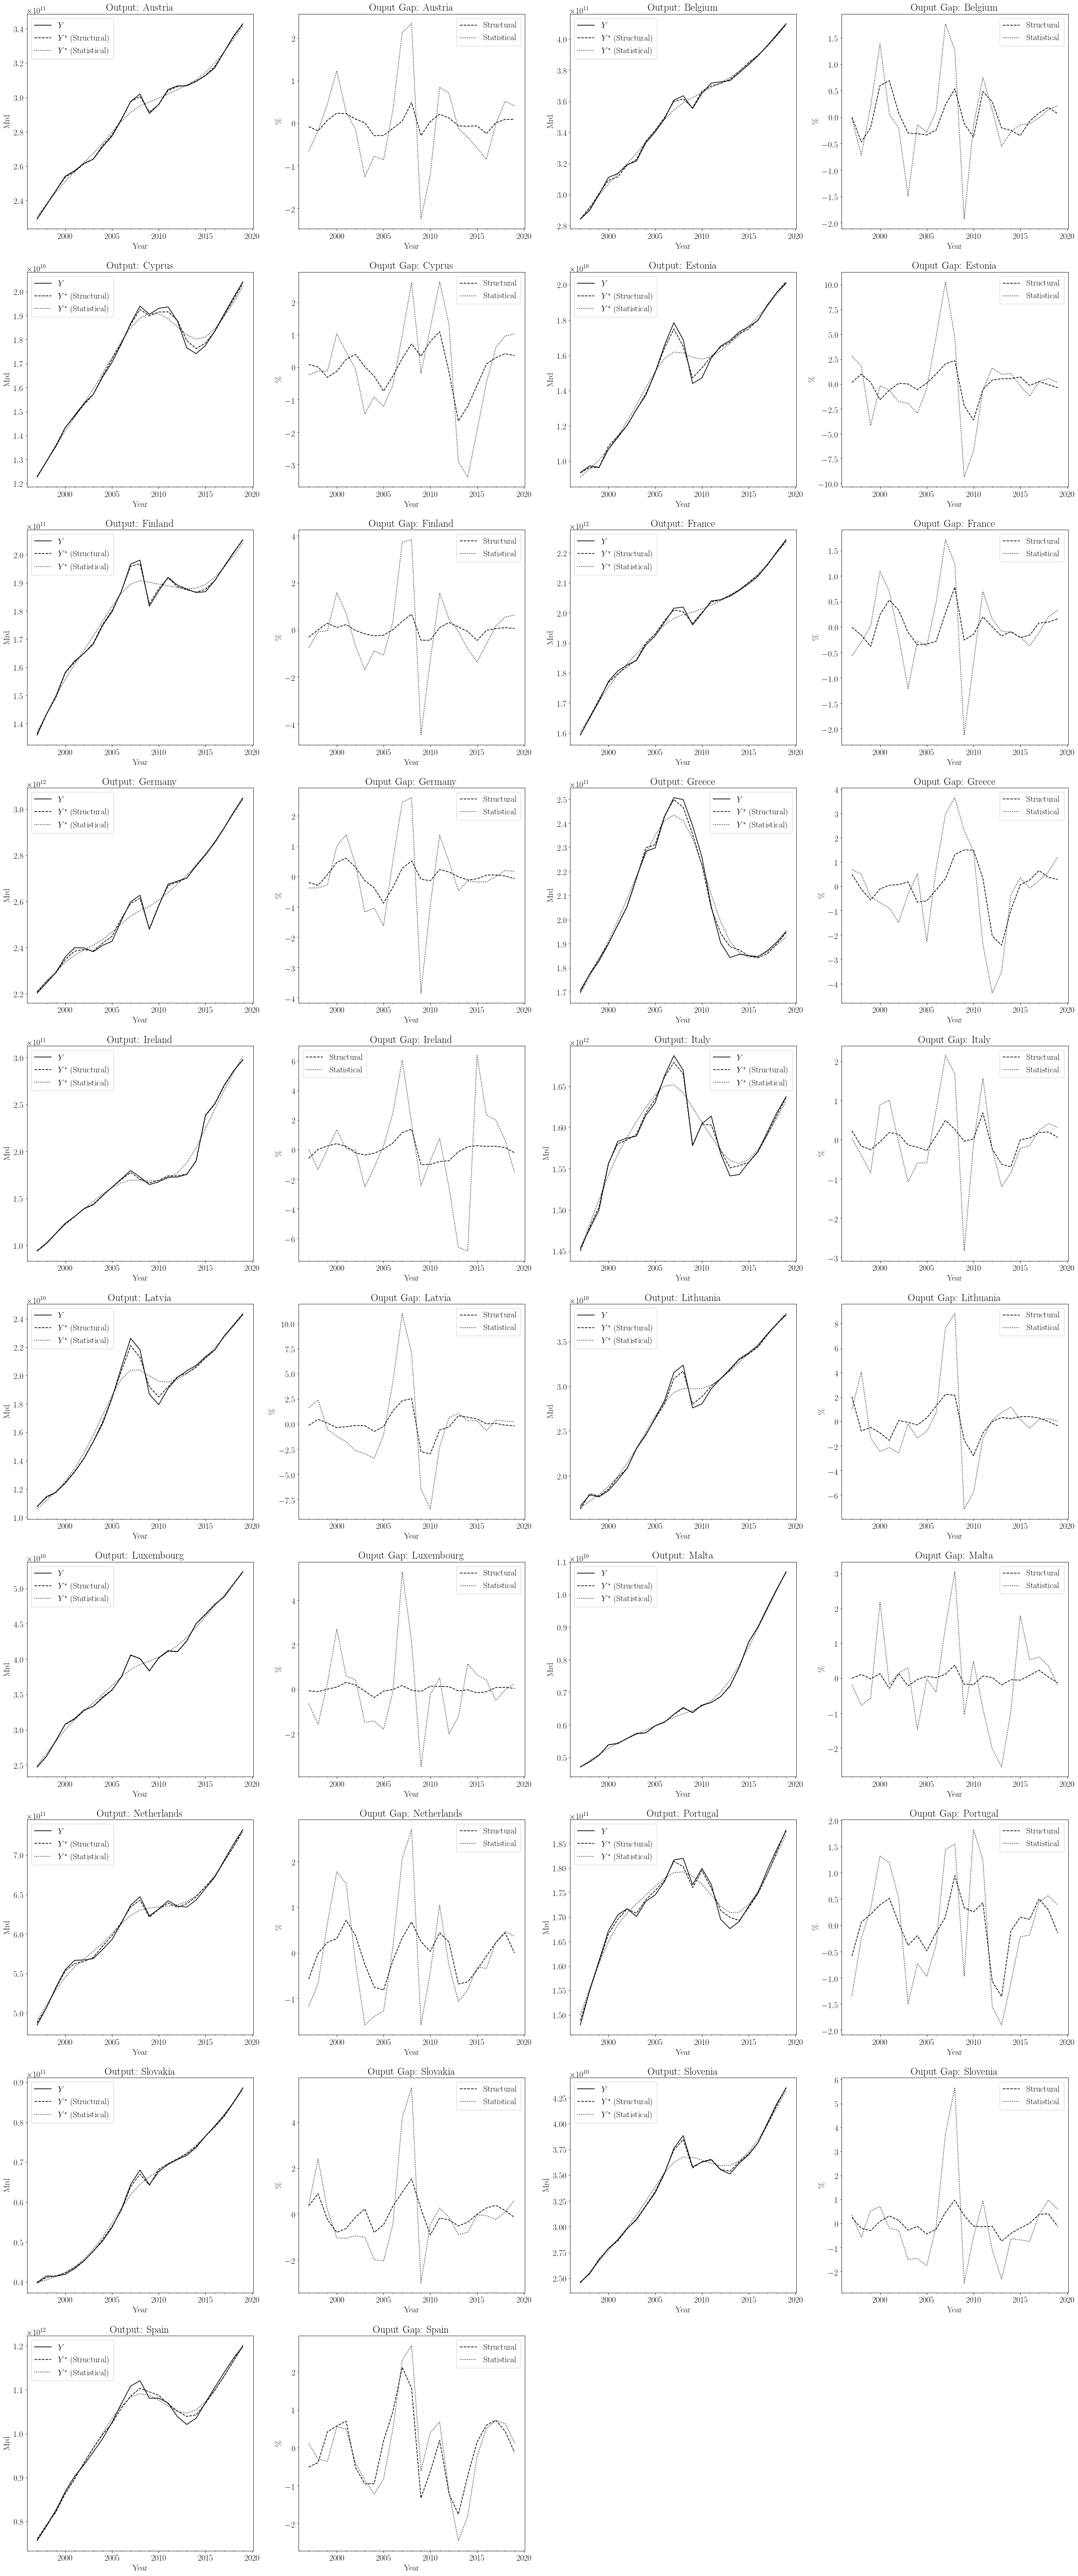

In [25]:
f, axes = plt.subplots(nrows=10, ncols=4, figsize=(40, 100)); axes = axes.flatten(); f.delaxes(axes[38]); f.delaxes(axes[39]); 
for i, country in enumerate(study_countries):
    df_temp1 = pd.DataFrame(index=range(1997, 2020)); df_temp1.index = pd.to_datetime(df_temp1.index, format='%Y')
    df_temp1["Historical"] = OVGD[country]; df_temp1["Structural"] = structural_potential[country]; df_temp1["Statistical"] = statistical_potential[country] 
    df_temp1.plot(style=['-','--',':'], color="black", ax=axes[i*2])
    axes[i*2].legend(labels=[r"$Y$", r"$Y^\star$ (Structural)", r"$Y^\star$ (Statistical)"])
    axes[i*2].set_title("Output: "+country, fontsize=22)
    axes[i*2].set_ylabel("Mrd")
    axes[i*2].set_xlabel("Year")

    df_temp2 = pd.DataFrame(index=range(1997, 2020)); df_temp2.index = pd.to_datetime(df_temp2.index, format='%Y')
    df_temp2["Structural"] = structural_gap[country]; df_temp2["Statistical"] = statistical_gap[country] 
    df_temp2.plot(style=['--',':'], color="black", ax=axes[i*2+1])
    axes[i*2+1].legend(labels=["Structural", "Statistical"])
    axes[i*2+1].set_title("Ouput Gap: "+country, fontsize=22)
    axes[i*2+1].set_ylabel("\%")
    axes[i*2+1].set_xlabel("Year")

_______

# $\textrm{Clustering and Correlations}$

In [26]:
def k_elbow(stat_gap, stru_gap):
    
    f, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    data_kmeans = stat_gap.T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
           
    axes[0].plot(n_cluster, res)
    axes[0].set_title("Cluster Selection, Elbow Criterion (Statistical)", fontsize=22)
    axes[0].set_ylabel("Distortion Score")
    axes[0].set_xlabel("Number of Clusters")
    
    
    data_kmeans = stru_gap.T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
          
    axes[1].plot(n_cluster, res)
    axes[1].set_title("Cluster Selection, Elbow Criterion (Structural)", fontsize=22)
    axes[1].set_ylabel("Distortion Score")
    axes[1].set_xlabel("Number of Clusters")

    plt.tight_layout()

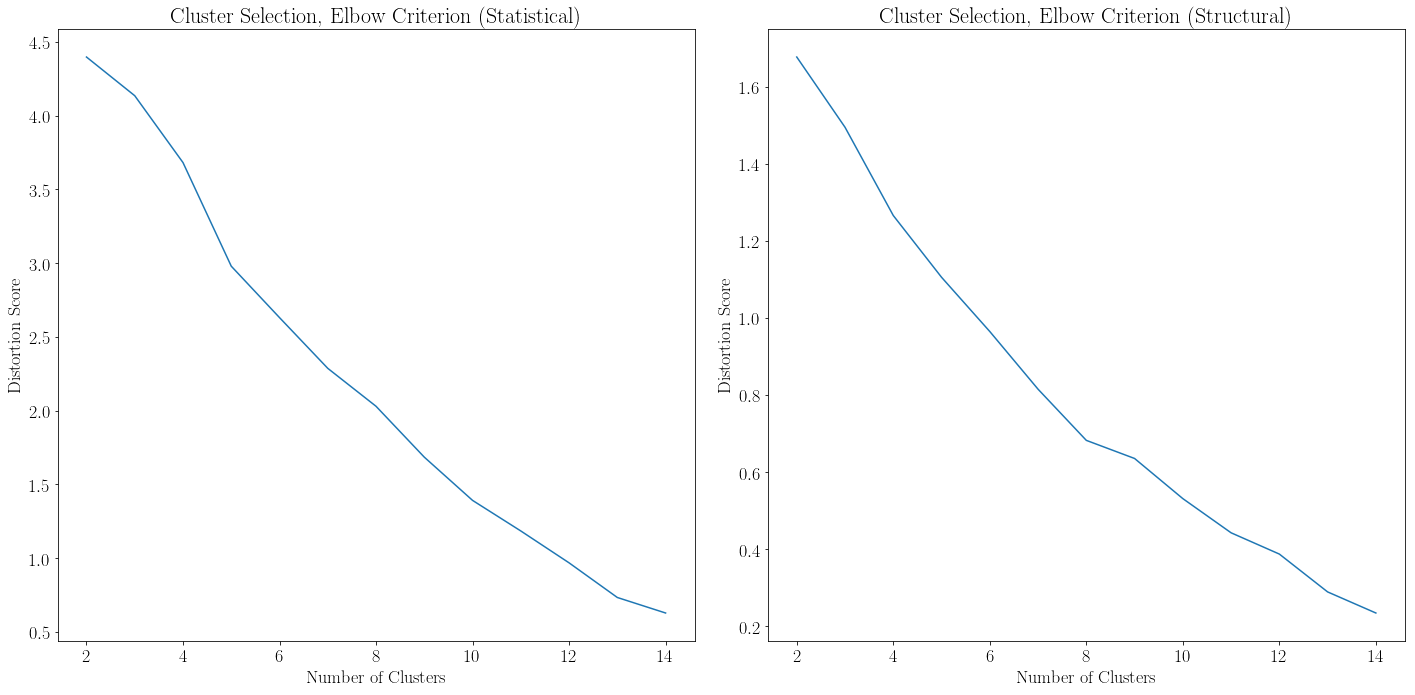

In [27]:
k_elbow(statistical_gap, structural_gap)

<br>

In [28]:
def countries_k(gap, n):
    
    data_kmeans = gap.T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
    
    return(km)

In [29]:
def corrs_potential(sta_gap, stru_gap, extra):
    
    n = 4
    clusters_table = pd.DataFrame(np.array([countries_k(stru_gap, n), countries_k(sta_gap, n)]).T, 
                                  index=stru_gap.columns, columns=["Structural", "Statistical"])
    sta_order = clusters_table.sort_values("Statistical").Statistical.index.values
    stru_order = clusters_table.sort_values("Structural").Structural.index.values
    
    f, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    sns.heatmap(sta_gap[sta_order].corr(), mask=np.zeros_like(sta_gap[sta_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[0]).set_title("Correlation Matrix of Output Gaps (Statistical)"+extra, fontsize=22)
    
    sns.heatmap(stru_gap[stru_order].corr(), mask=np.zeros_like(stru_gap[stru_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[1]).set_title("Correlation Matrix of Output Gaps (Structural)"+extra, fontsize=22)
    
    plt.tight_layout()

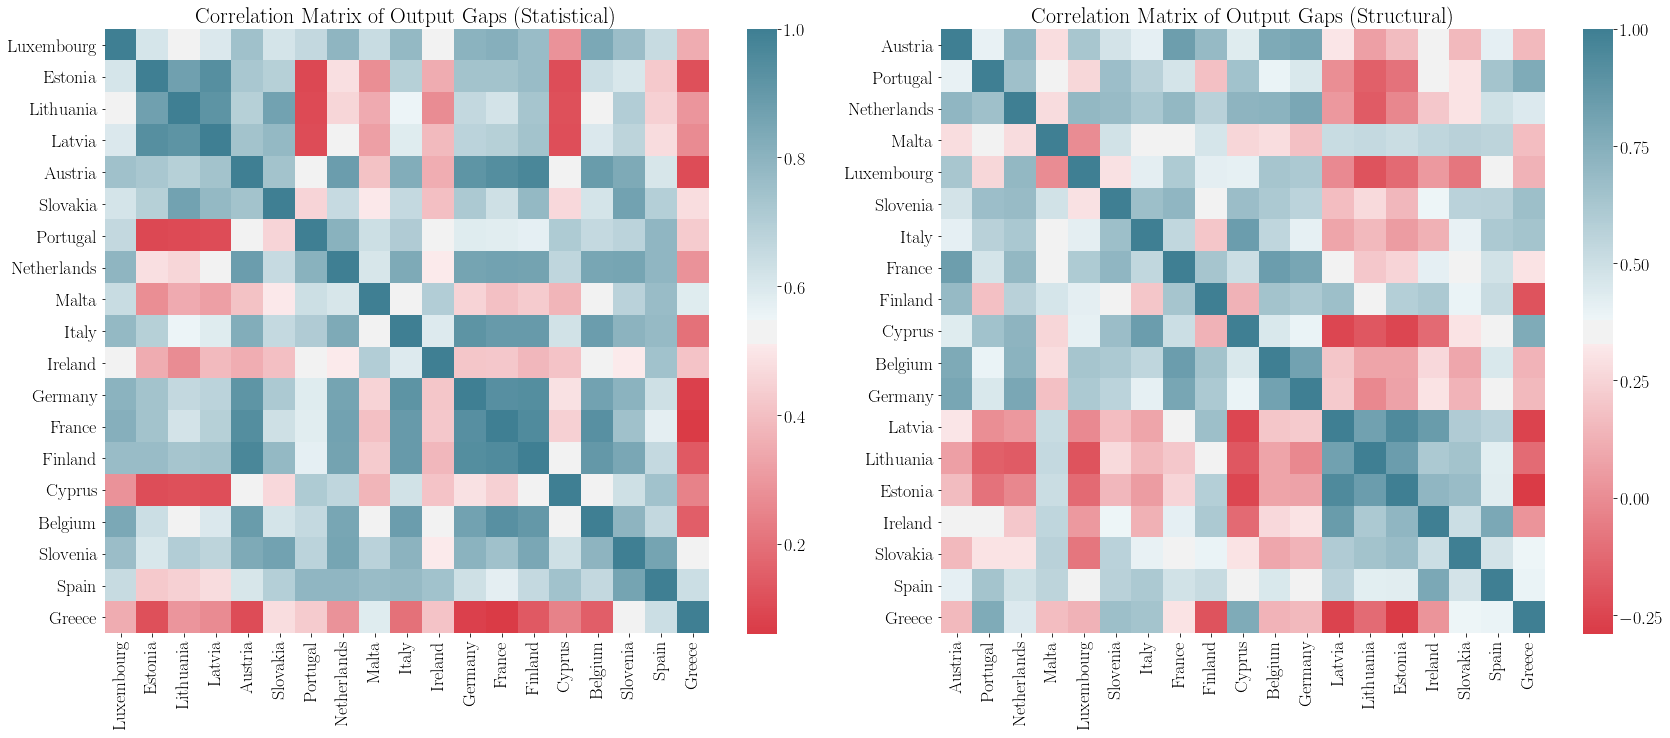

In [30]:
corrs_potential(statistical_gap, structural_gap, "")

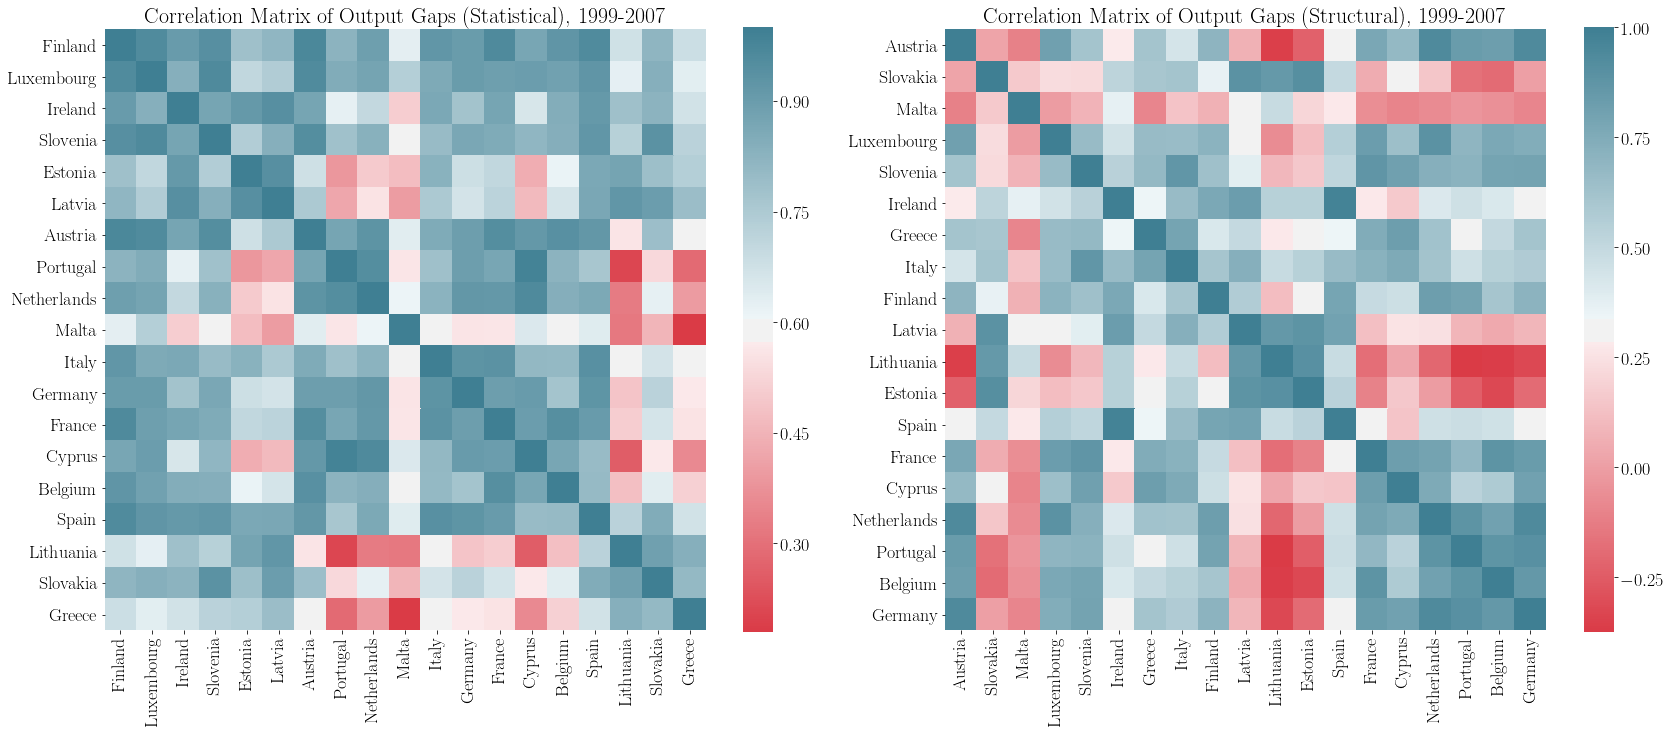

In [31]:
corrs_potential(statistical_gap.loc["1999-01-01" : "2007-01-01"], structural_gap.loc["1999-01-01" : "2007-01-01"], ", 1999-2007")

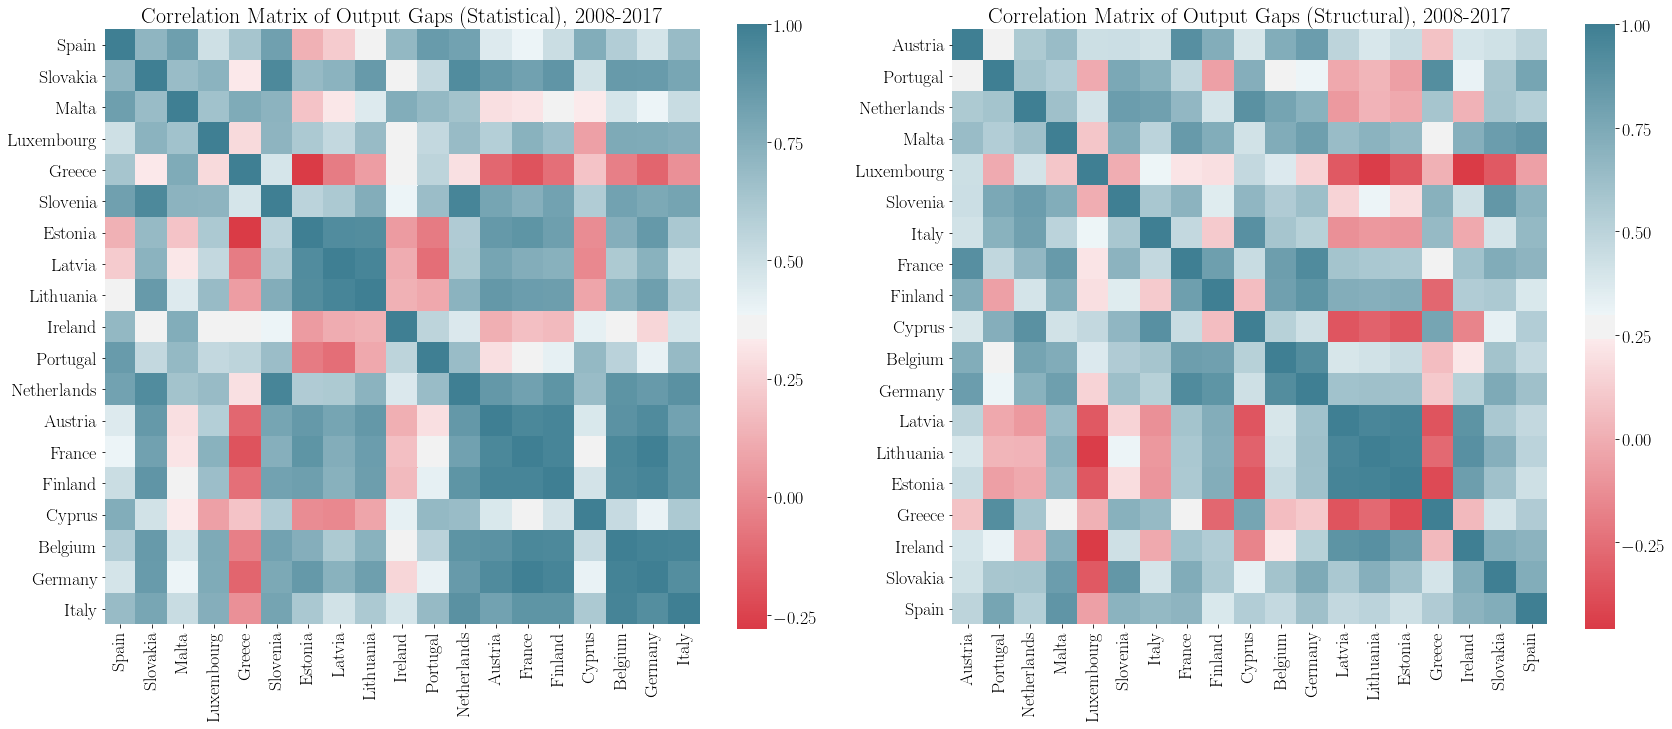

In [32]:
corrs_potential(statistical_gap.loc["2008-01-01" : "2017-01-01"], structural_gap.loc["2008-01-01" : "2017-01-01"], ", 2008-2017")

In [33]:
def corrs_potential_nk(sta_gap, stru_gap, extra):
       
    f, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    sns.heatmap(sta_gap.corr(), mask=np.zeros_like(sta_gap.corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), ax=axes[0]).set_title("Correlation Matrix of Output Gaps (Statistical)"+extra, fontsize=22)
    
    sns.heatmap(stru_gap.corr(), mask=np.zeros_like(stru_gap.corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), ax=axes[1]).set_title("Correlation Matrix of Output Gaps (Structural)"+extra, fontsize=22)
    
    plt.tight_layout()

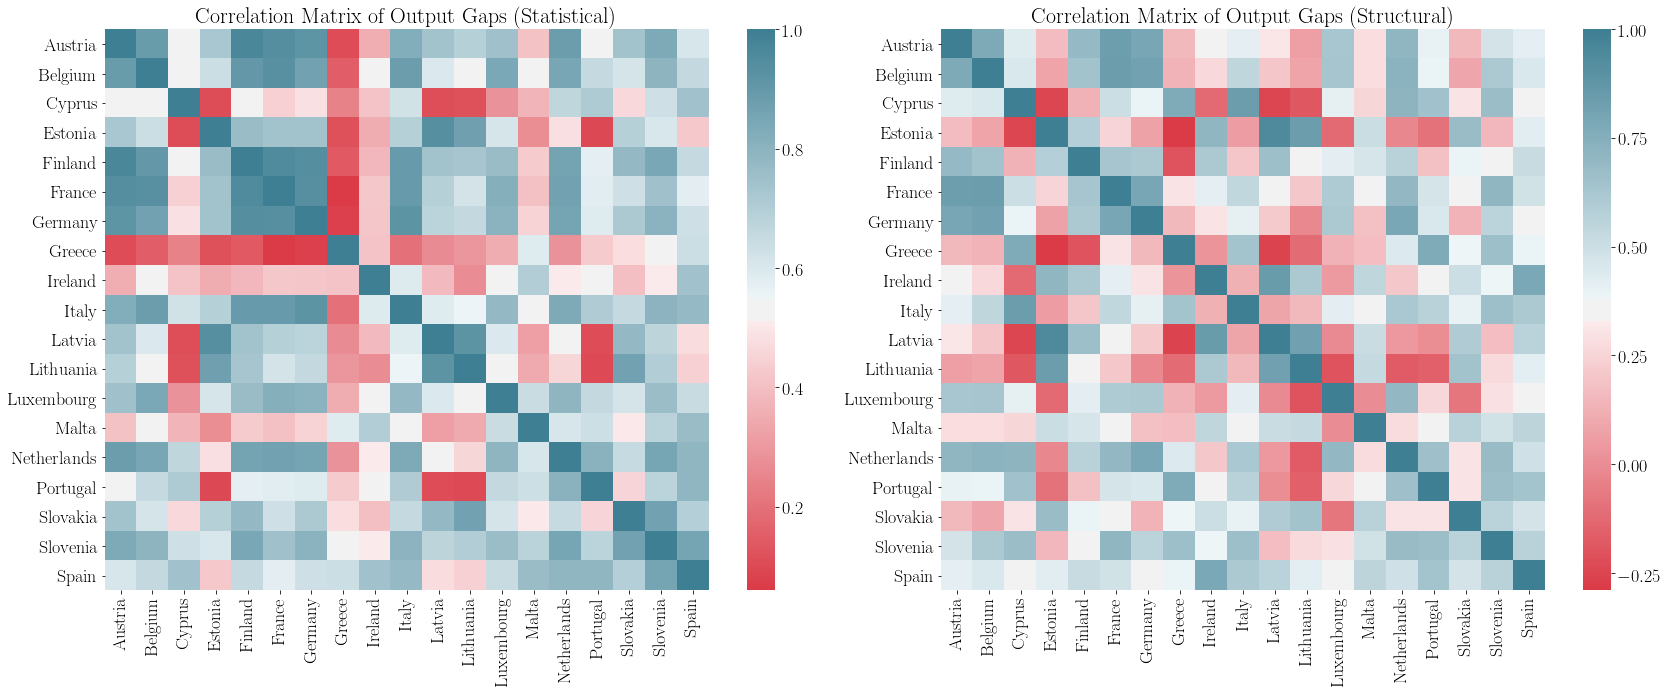

In [34]:
corrs_potential_nk(statistical_gap, structural_gap, "")

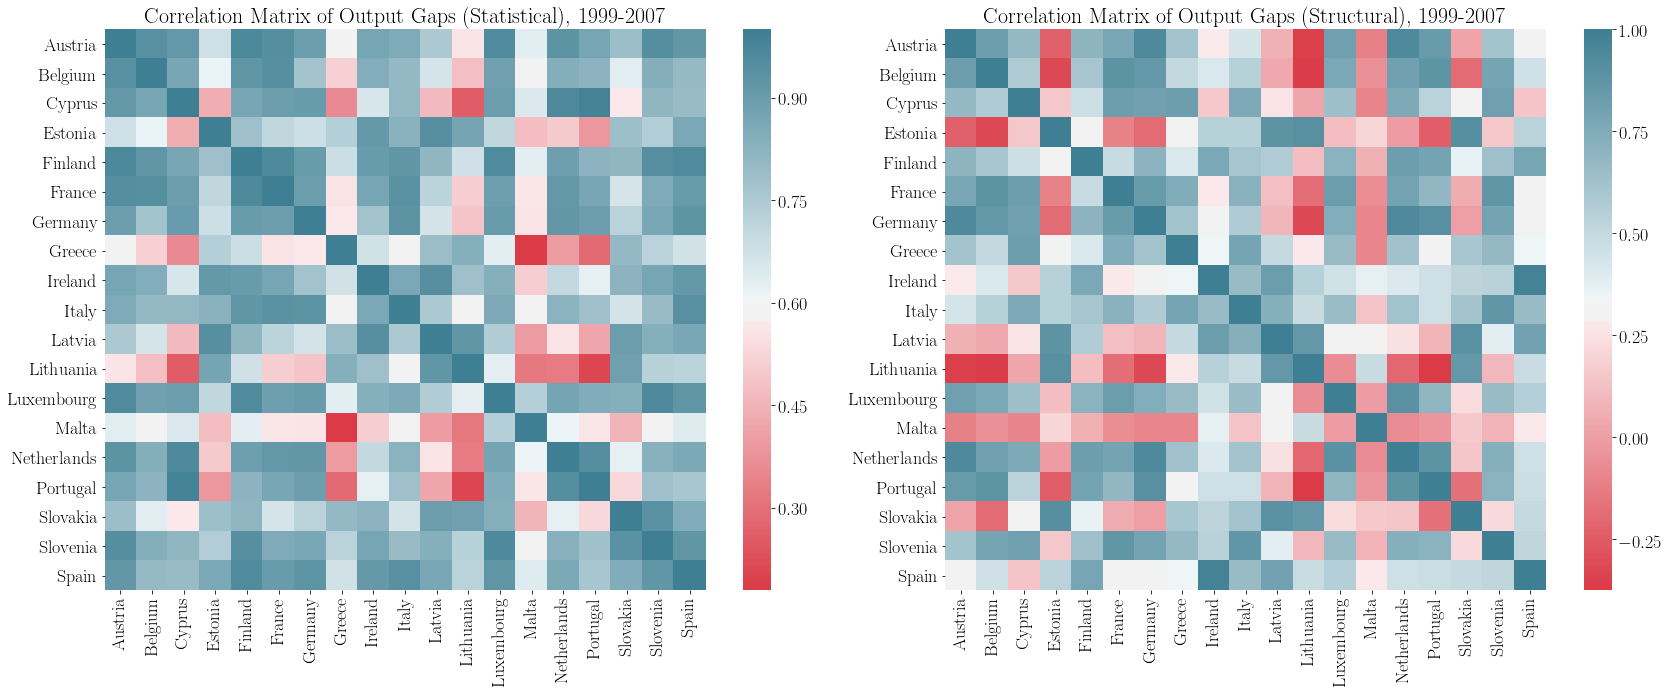

In [35]:
corrs_potential_nk(statistical_gap.loc["1999-01-01" : "2007-01-01"], structural_gap.loc["1999-01-01" : "2007-01-01"], ", 1999-2007")

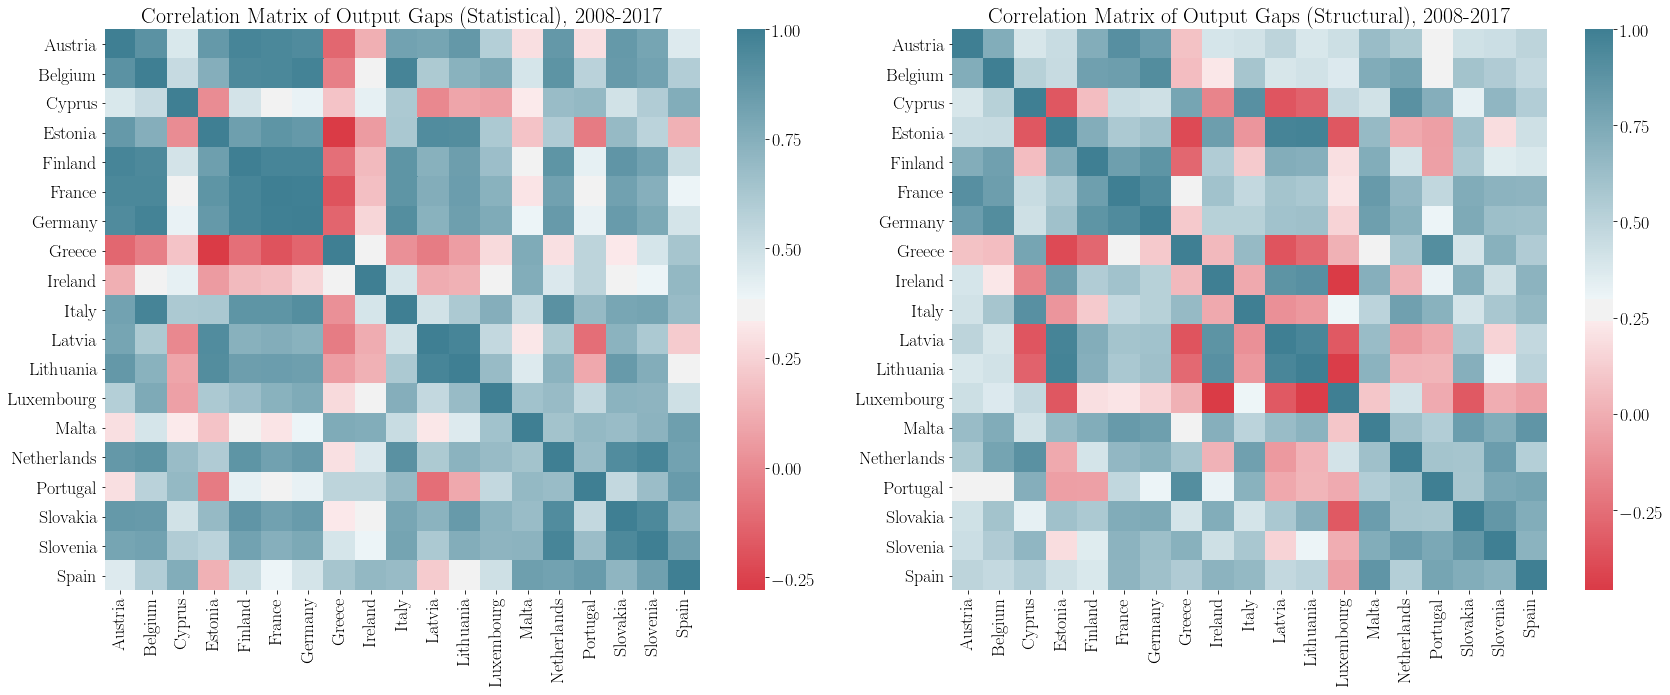

In [36]:
corrs_potential_nk(statistical_gap.loc["2008-01-01" : "2017-01-01"], structural_gap.loc["2008-01-01" : "2017-01-01"], ", 2008-2017")

<br>

____________

# $\textrm{Growth Accounting}$

In [37]:
def growth_decomposition(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    data_input=data_input[data_input.year >= 1997]
    
    dY = pd.DataFrame(index=study_years[1:]);
    dZ = dY.copy(); dK = dY.copy(); dN = dY.copy(); adK = dY.copy(); bdN = dY.copy()
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.astype(float)
        
        # Add dY
        dY[country] = np.log(country_indicators["OVGD"].values[1:])-np.log(country_indicators["OVGD"].values[:-1])
        
        # Calculate N
        country_indicators["N"] = (-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]
                       
        # Calculate a
        country_indicators["a"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        
        # Calculate Z
        country_indicators["Z"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["a"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["a"]+1))
        
        # Add dN 
        bdN[country] = ((-country_indicators["a"]+1)*np.log(country_indicators["N"])).values[1:]-((-country_indicators["a"]+1)*np.log(country_indicators["N"])).values[:-1]
        
        # Add dK
        adK[country] = (country_indicators["a"]*np.log(country_indicators["OKND"])).values[1:]-(country_indicators["a"]*np.log(country_indicators["OKND"])).values[:-1]
        
        # Add dZ
        dZ[country] = np.log(country_indicators["Z"].values[1:])-np.log(country_indicators["Z"].values[:-1])
                    
    return(dY*100, dZ*100, adK*100, bdN*100)

In [38]:
dY, dZ, adK, bdN = growth_decomposition(data, study_countries)

<br>

In [39]:
def graph_growth(d, indicator):
        
    plt.figure()
    d.plot(figsize=(20, 10), colormap="tab20")
    plt.title(indicator+", Eurozone", fontsize=22)
    plt.ylabel(indicator+", \%")
    plt.xlabel("Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    
    ##
    n = 4
    data_kmeans = d.T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
    clusters_table = pd.DataFrame(np.array(km), index=d.columns, columns=["Cat"])
    corr_order = clusters_table.sort_values("Cat").Cat.index.values
    
    plt.figure(figsize=(14,10))
    sns.heatmap(d[corr_order].corr(), mask=np.zeros_like(d[corr_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True).set_title("Correlation Matrix of "+indicator+", Eurozone", fontsize=22)
    plt.show()

In [40]:
def std_deltas_accounting(d_Y, d_Z, ad_K, bd_N):
    
    tempor = pd.DataFrame(index = range(1997, 2020))
    tempor["dY"] = d_Y.std(axis=1); tempor["dZ"] = d_Z.std(axis=1); tempor["adK"] = ad_K.std(axis=1); tempor["bdN"] = bd_N.std(axis=1); 
    
    f, ax = plt.subplots()
    tempor.plot(style=["-", '--', "-.", ':'], figsize=(20, 10), color="black", ax=ax)
    ax.legend(labels=[r"$\widehat{Y_t}$", r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    ax.set_title("Standard Deviation of Growth Accounting , Eurozone ", fontsize=22)
    ax.set_ylabel("Standard Deviation")
    ax.set_xlabel("Year")


<br>

<Figure size 432x288 with 0 Axes>

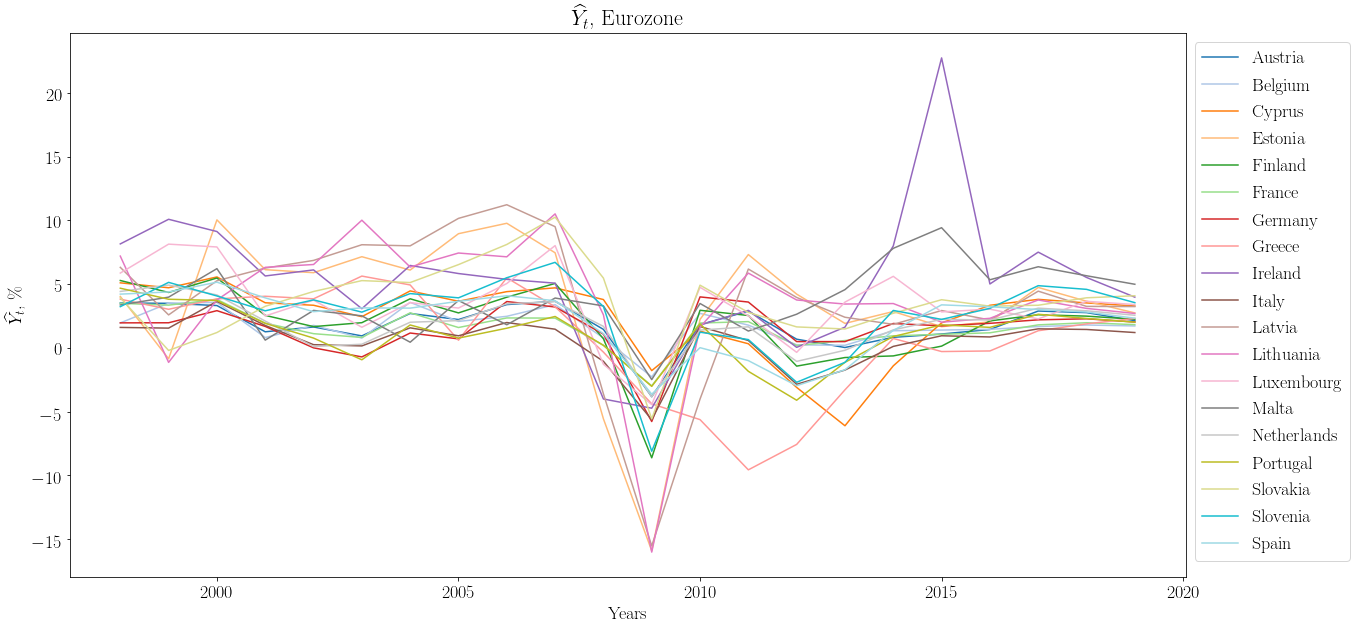

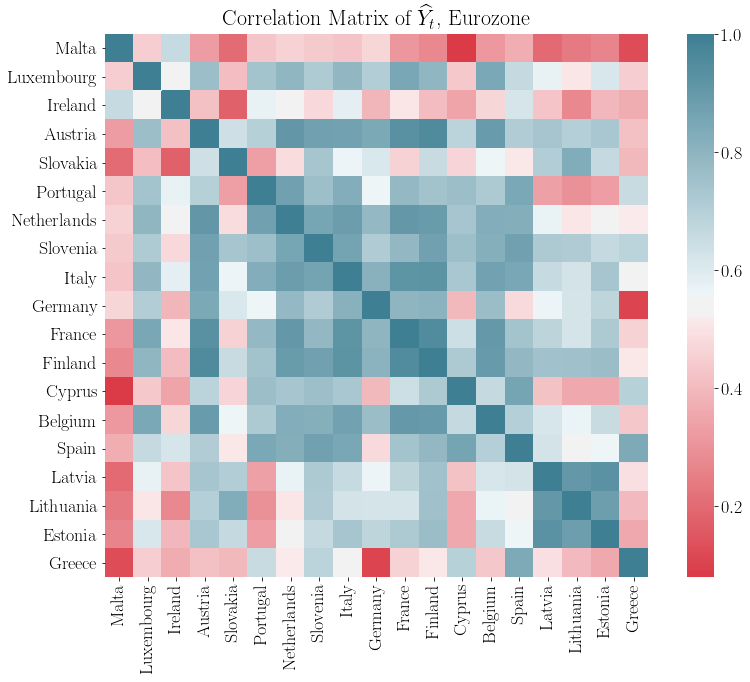

<Figure size 432x288 with 0 Axes>

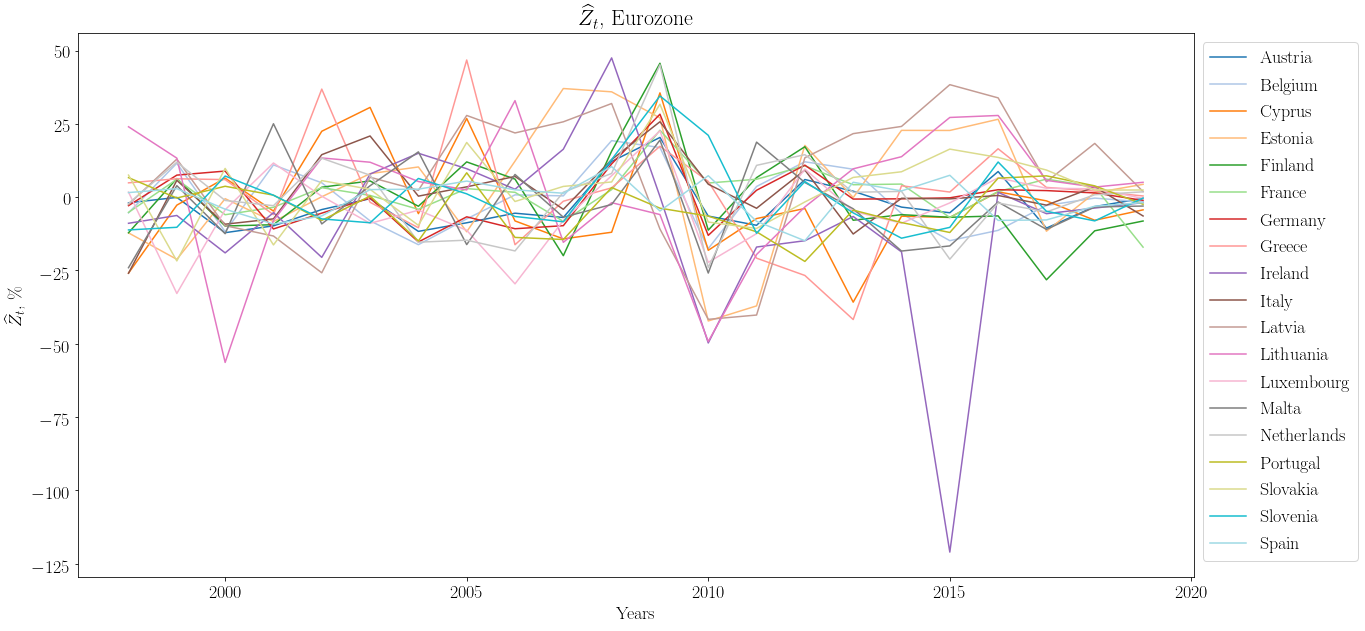

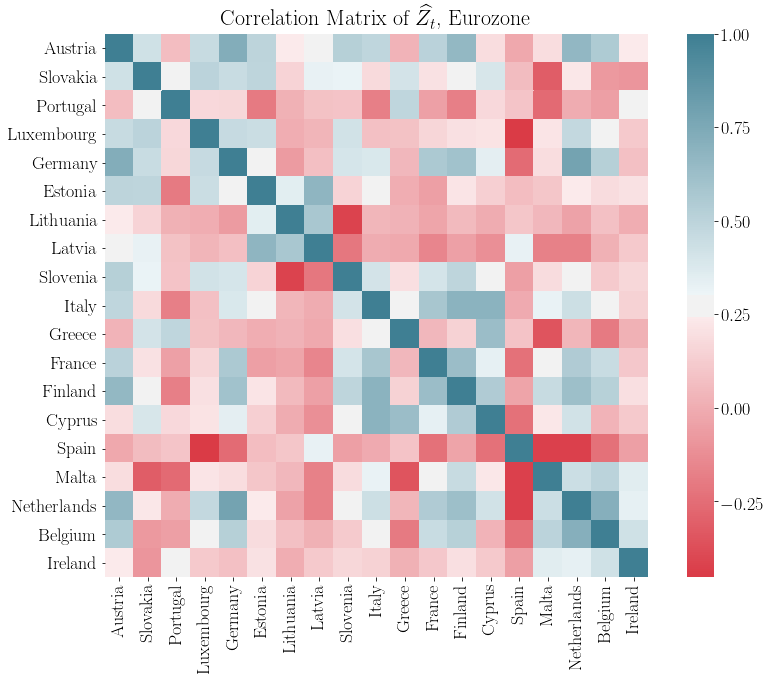

<Figure size 432x288 with 0 Axes>

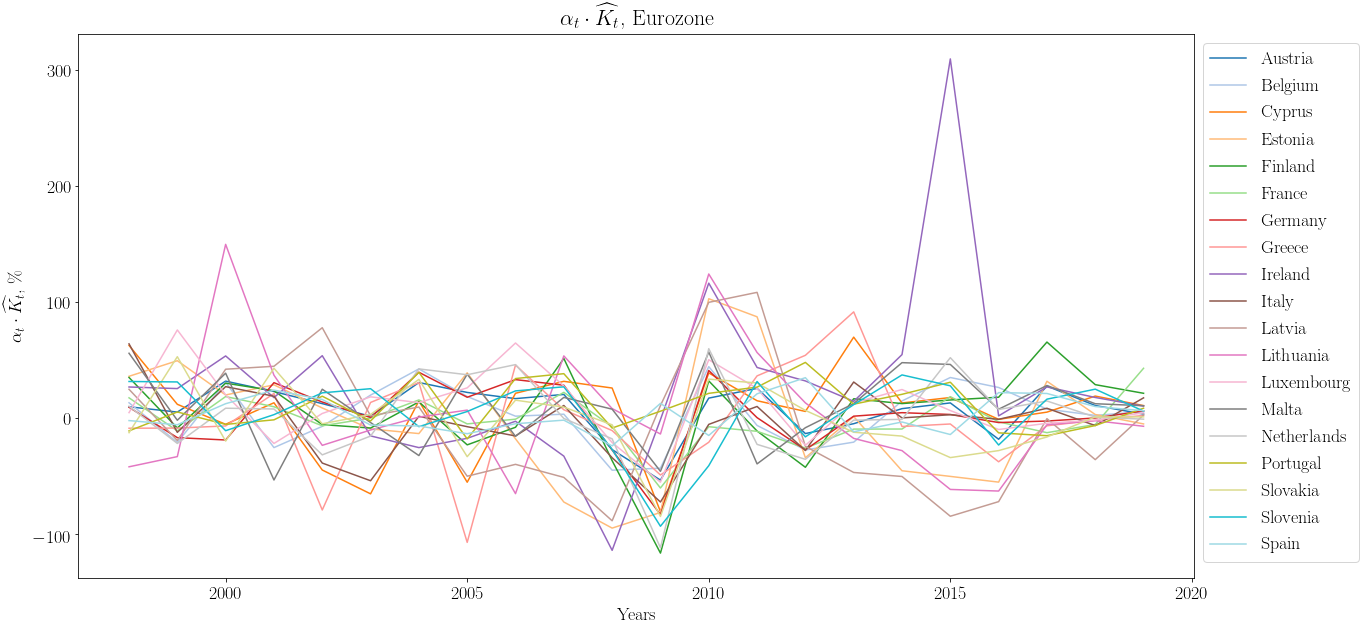

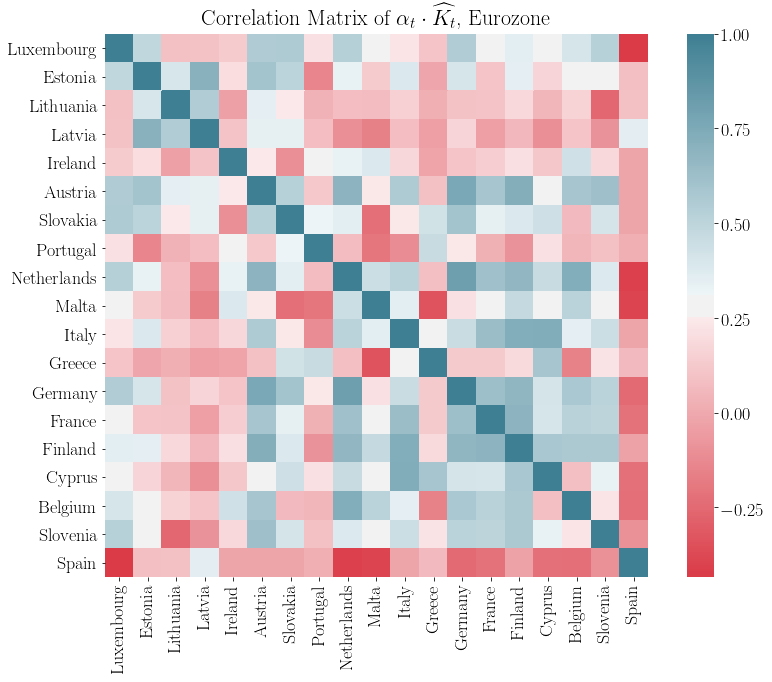

<Figure size 432x288 with 0 Axes>

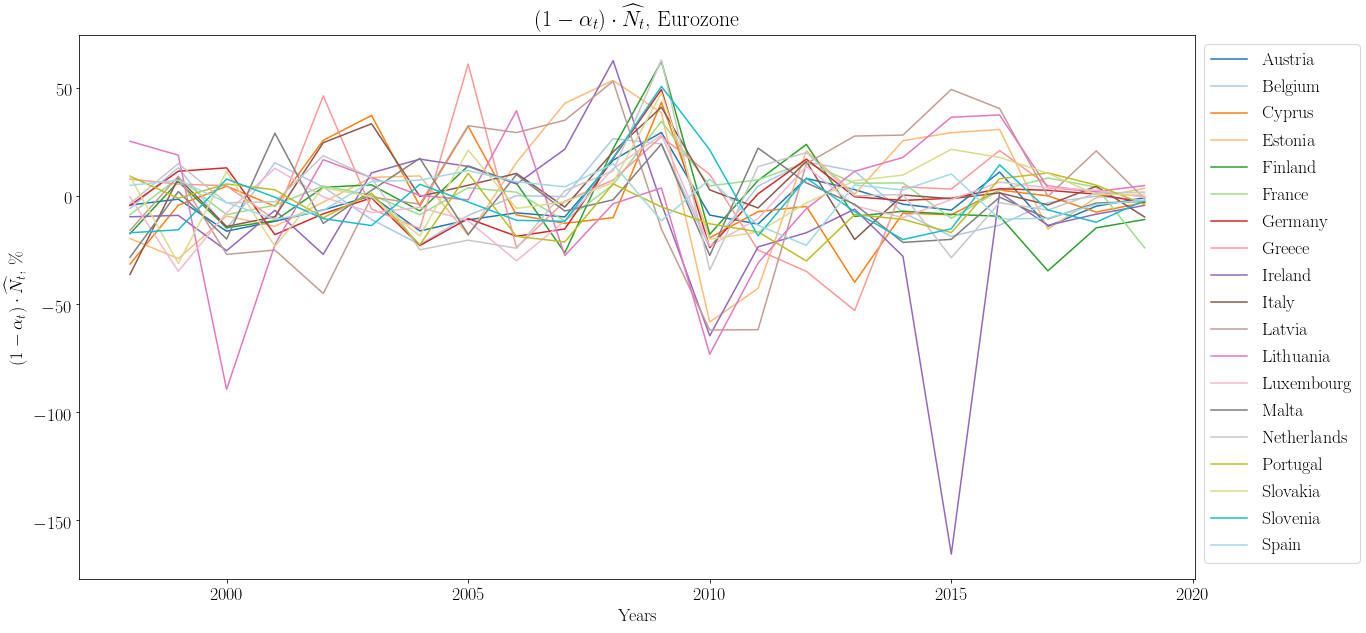

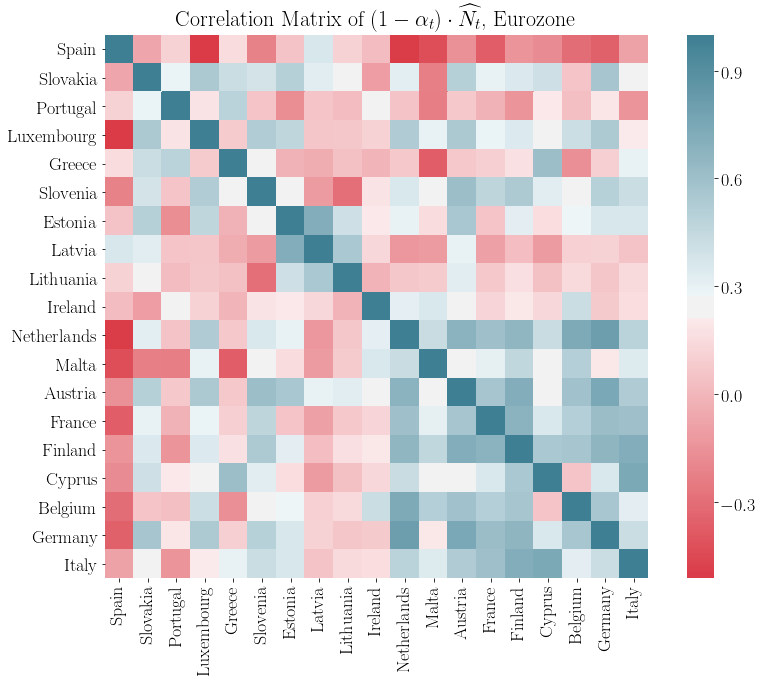

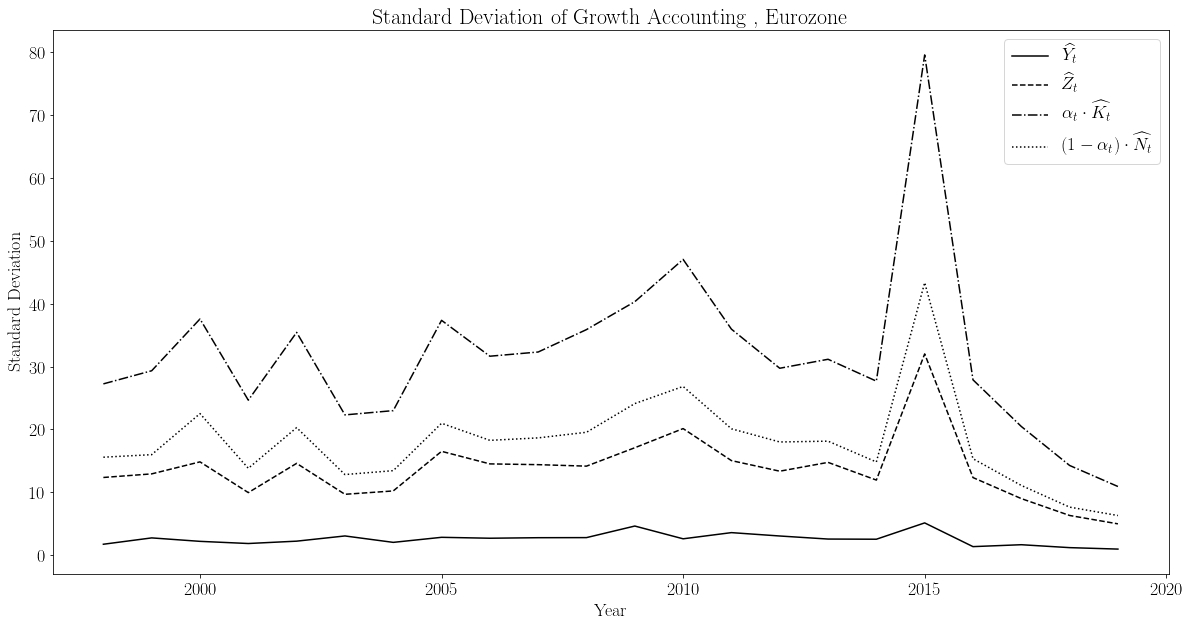

In [41]:
graph_growth(dY, r"$\widehat{Y_t}$")
graph_growth(dZ, r"$ \widehat{Z_t}$")
graph_growth(adK, r"$\alpha_t \cdot \widehat{K_t}$")
graph_growth(bdN, r"$(1-\alpha_t) \cdot \widehat{N_t}$")
std_deltas_accounting(dY, dZ, adK, bdN)

<br>

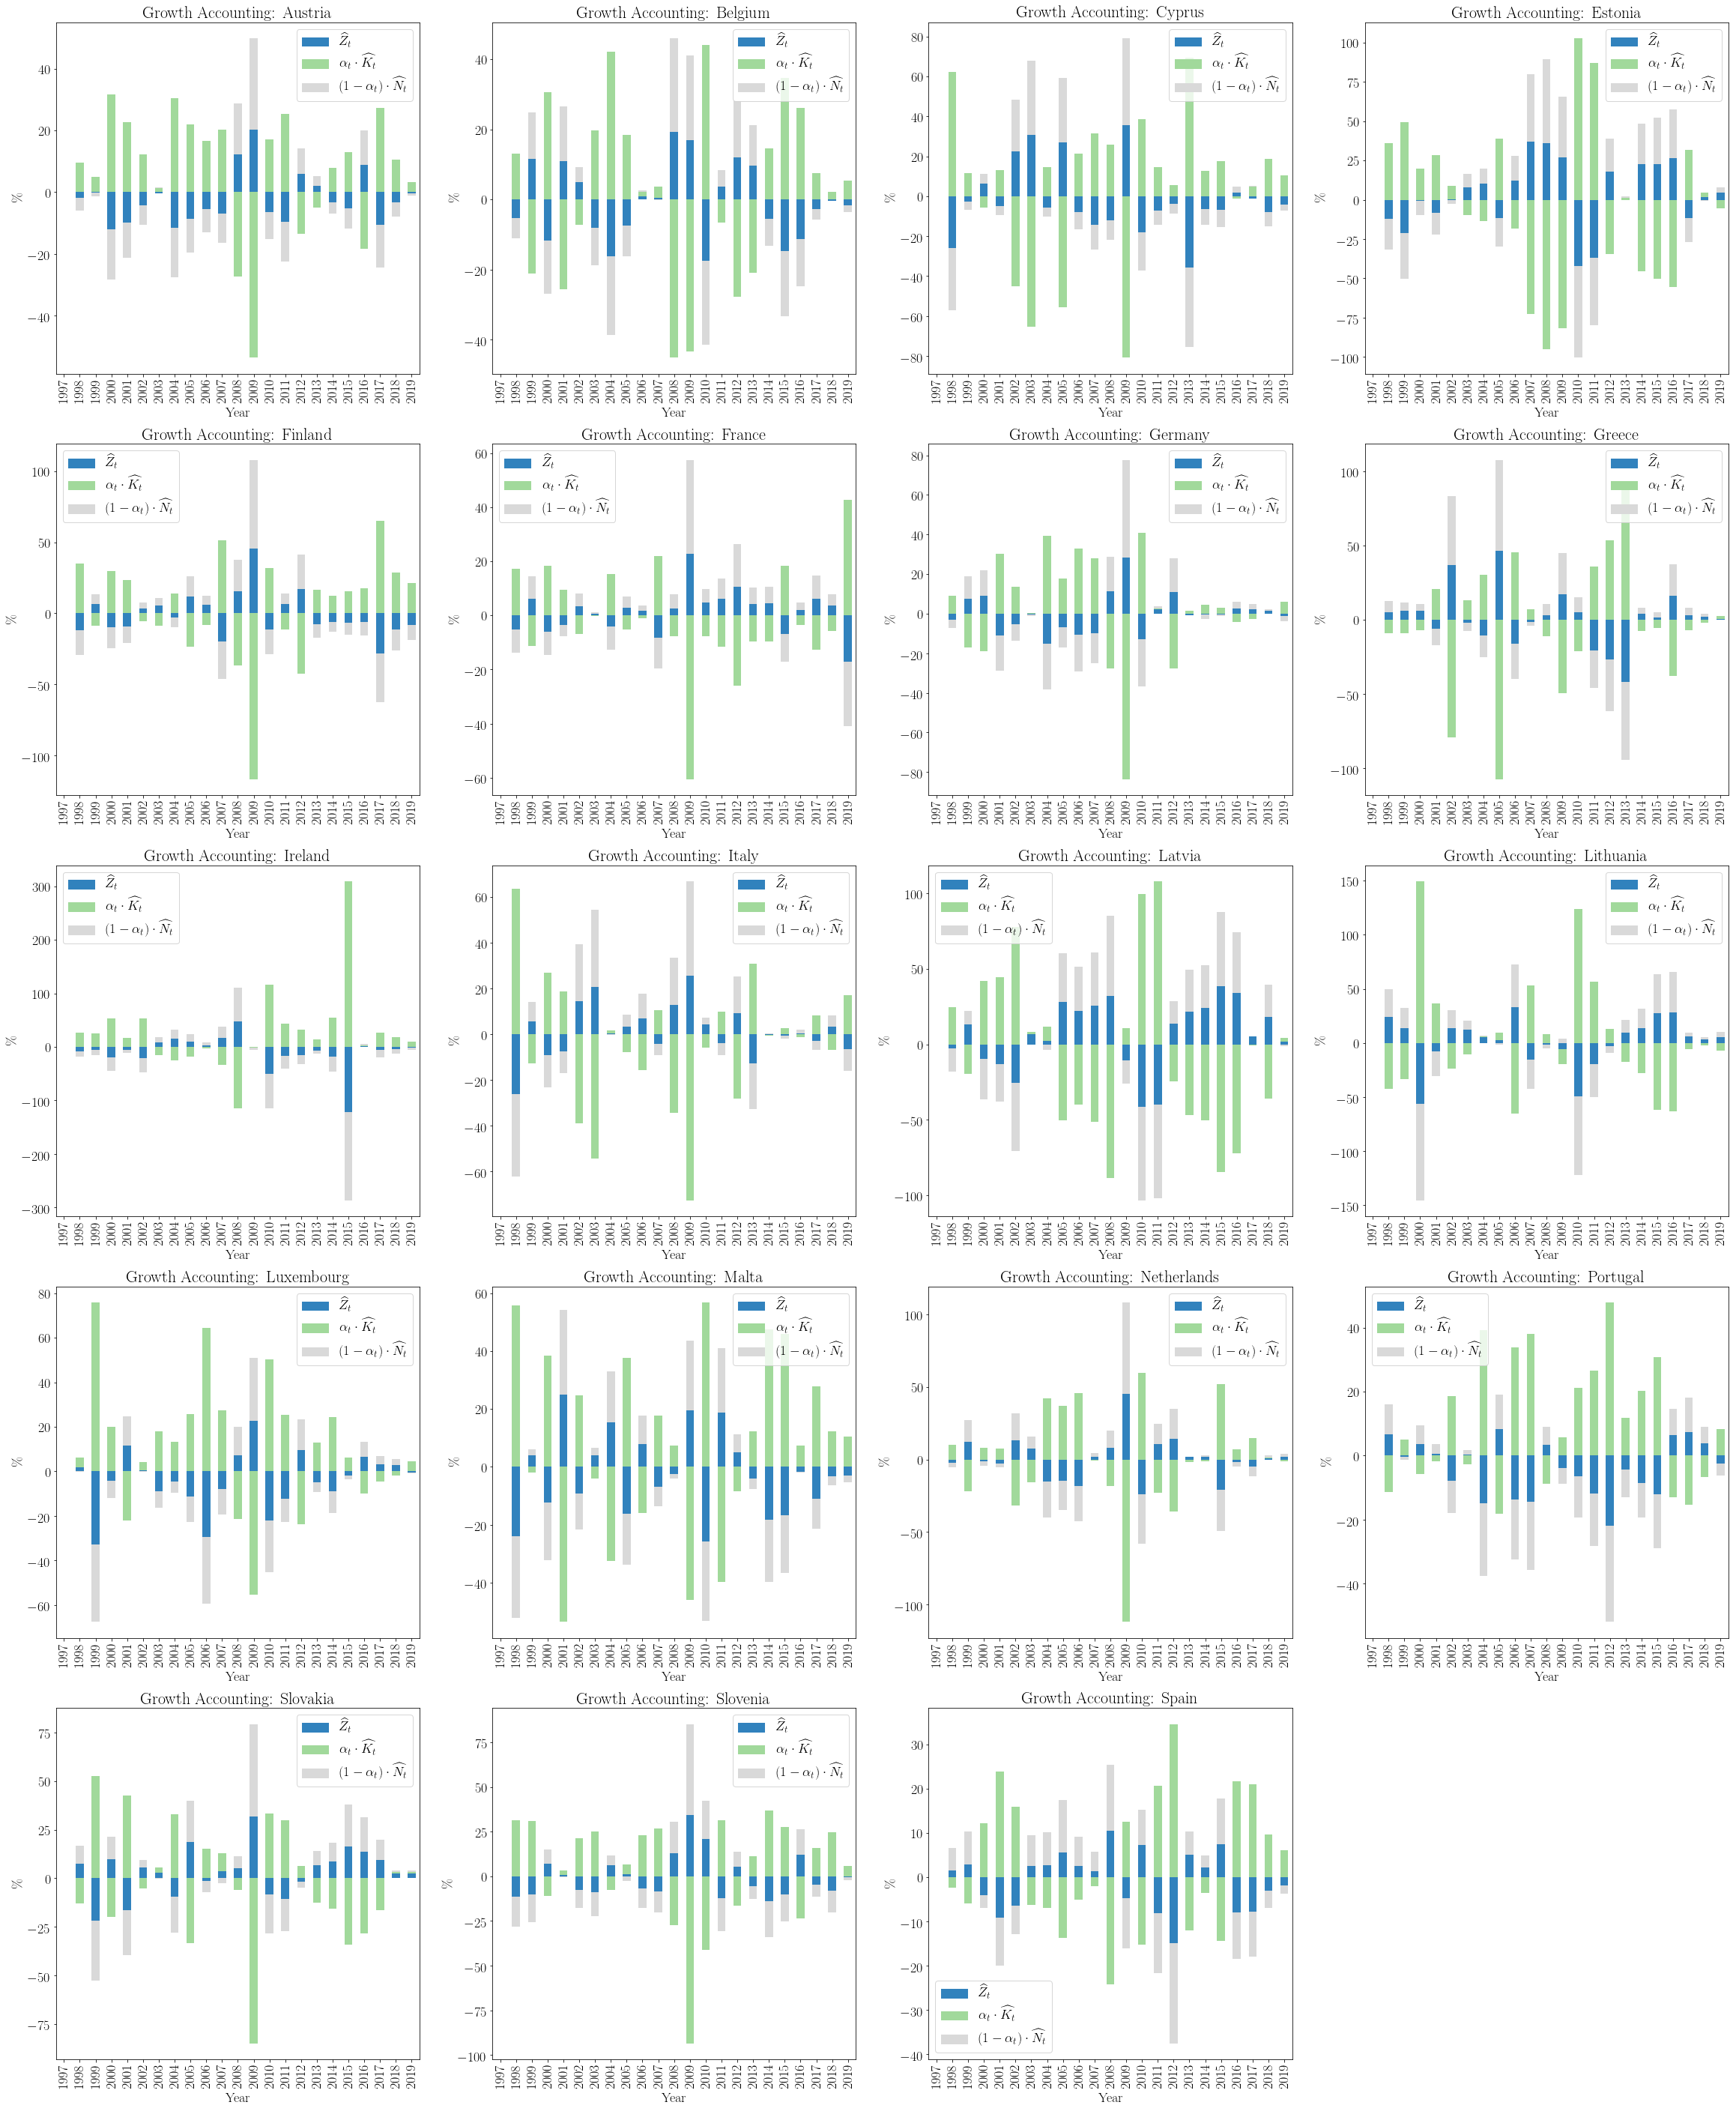

In [42]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize=(40, 50)); axes = axes.flatten(); f.delaxes(axes[19]); 
for i, country in enumerate(study_countries):
    df_temp = pd.DataFrame(index=range(1997, 2020)); #df_temp.index = pd.to_datetime(df_temp.index, format='%Y')
    df_temp["dZ"] = dZ[country]; df_temp["adK"] = adK[country]; df_temp["bdN"] = bdN[country] 
    df_temp.plot.bar(stacked=True, ax=axes[i], cmap=plt.cm.get_cmap('tab20c'))
    axes[i].legend(labels=[r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    axes[i].set_title("Growth Accounting: "+country, fontsize=22)
    axes[i].set_ylabel("\%")
    axes[i].set_xlabel("Year")

<br>

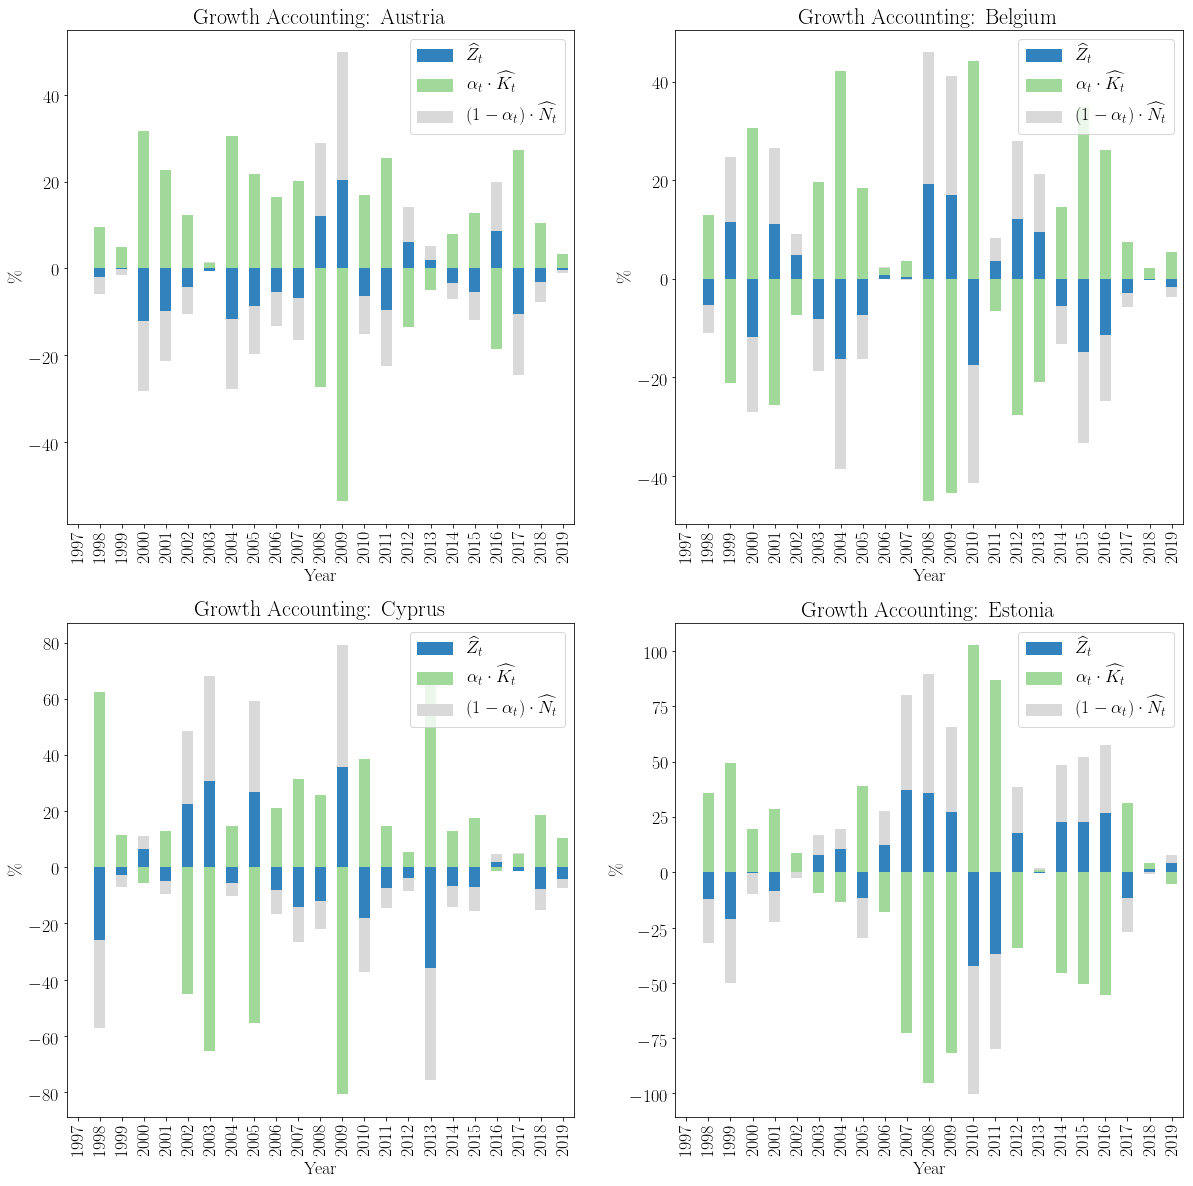

In [43]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20)); axes = axes.flatten()
level = 0
for i in range(0,4):    
    df_temp = pd.DataFrame(index=range(1997, 2020)); #df_temp.index = pd.to_datetime(df_temp.index, format='%Y')
    df_temp["dZ"] = dZ[study_countries[i+level]]; df_temp["adK"] = adK[study_countries[i+level]]; df_temp["bdN"] = bdN[study_countries[i+level]] 
    df_temp.plot.bar(stacked=True, ax=axes[i], cmap=plt.cm.get_cmap('tab20c'))
    axes[i].legend(labels=[r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    axes[i].set_title("Growth Accounting: "+study_countries[i+level], fontsize=22)
    axes[i].set_ylabel("\%")
    axes[i].set_xlabel("Year")

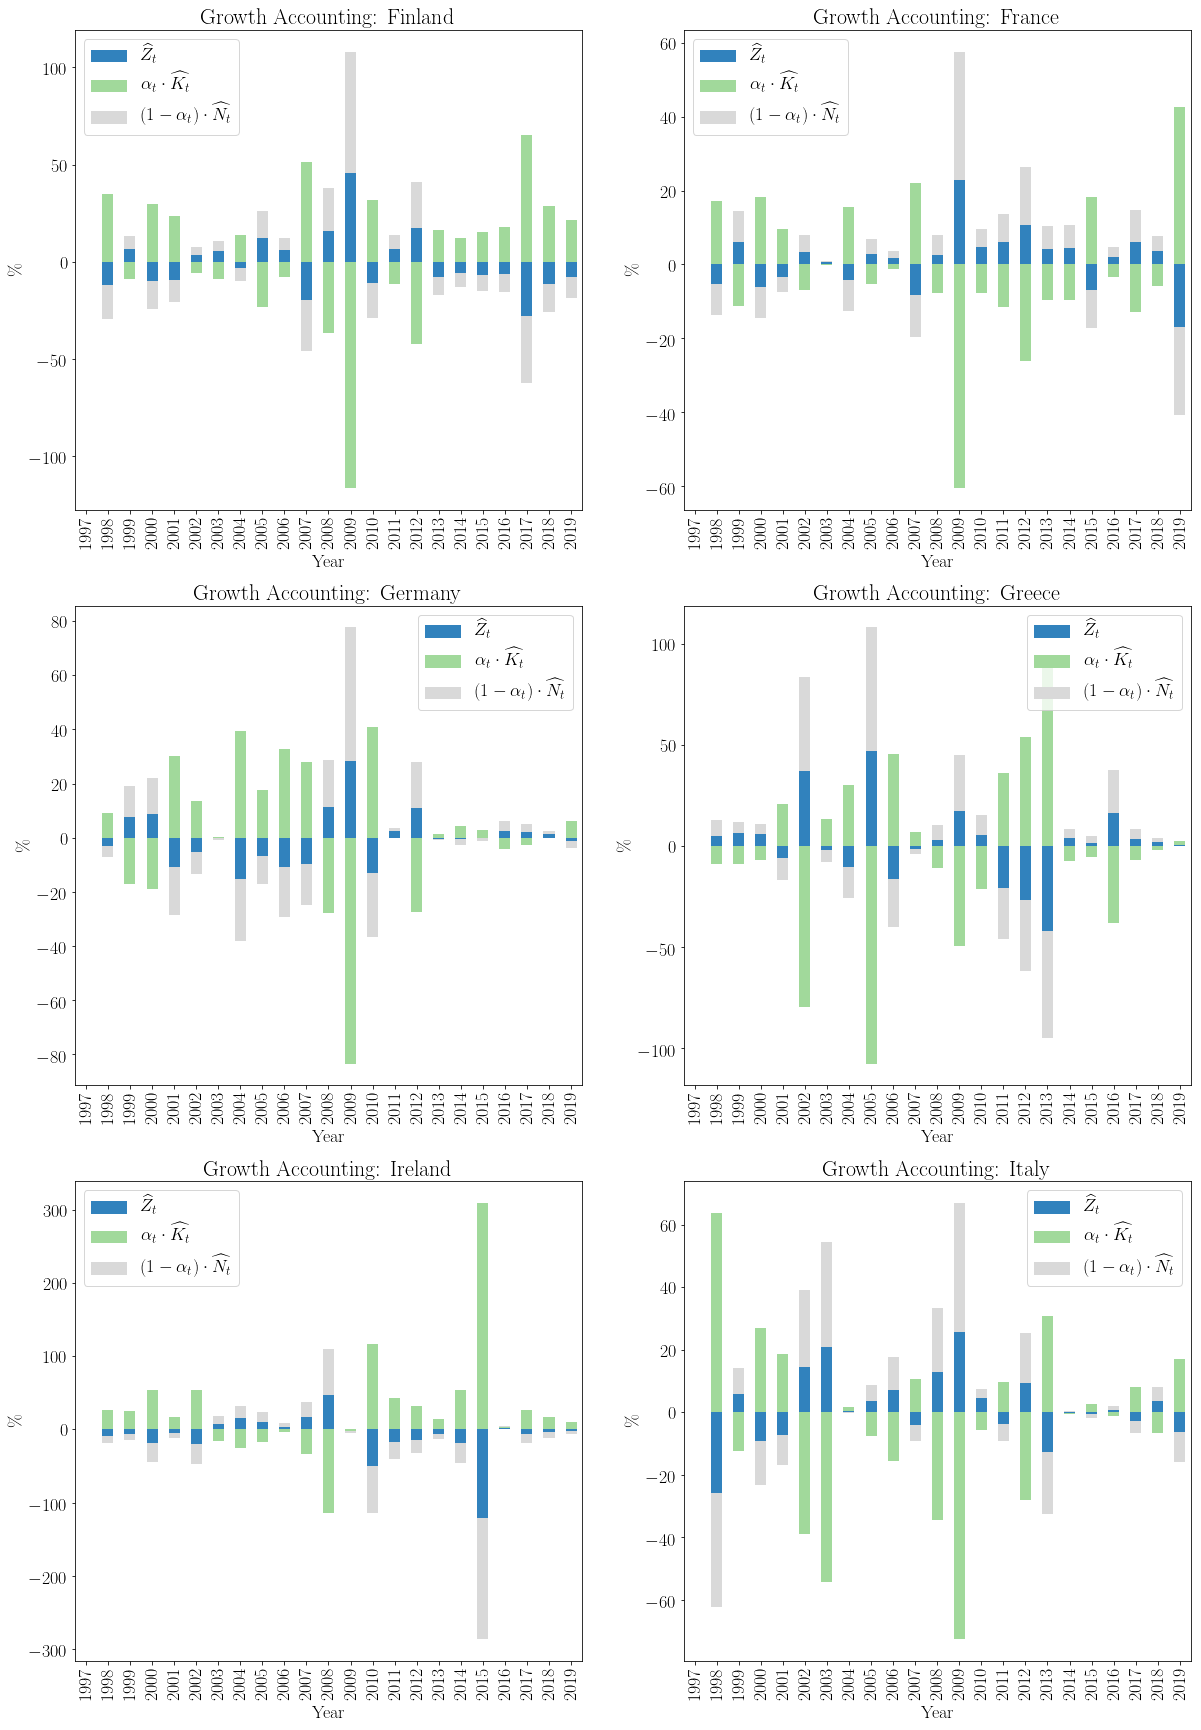

In [44]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()
level = 4
for i in range(0,6):    
    df_temp = pd.DataFrame(index=range(1997, 2020)); #df_temp.index = pd.to_datetime(df_temp.index, format='%Y')
    df_temp["dZ"] = dZ[study_countries[i+level]]; df_temp["adK"] = adK[study_countries[i+level]]; df_temp["bdN"] = bdN[study_countries[i+level]] 
    df_temp.plot.bar(stacked=True, ax=axes[i], cmap=plt.cm.get_cmap('tab20c'))
    axes[i].legend(labels=[r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    axes[i].set_title("Growth Accounting: "+study_countries[i+level], fontsize=22)
    axes[i].set_ylabel("\%")
    axes[i].set_xlabel("Year")

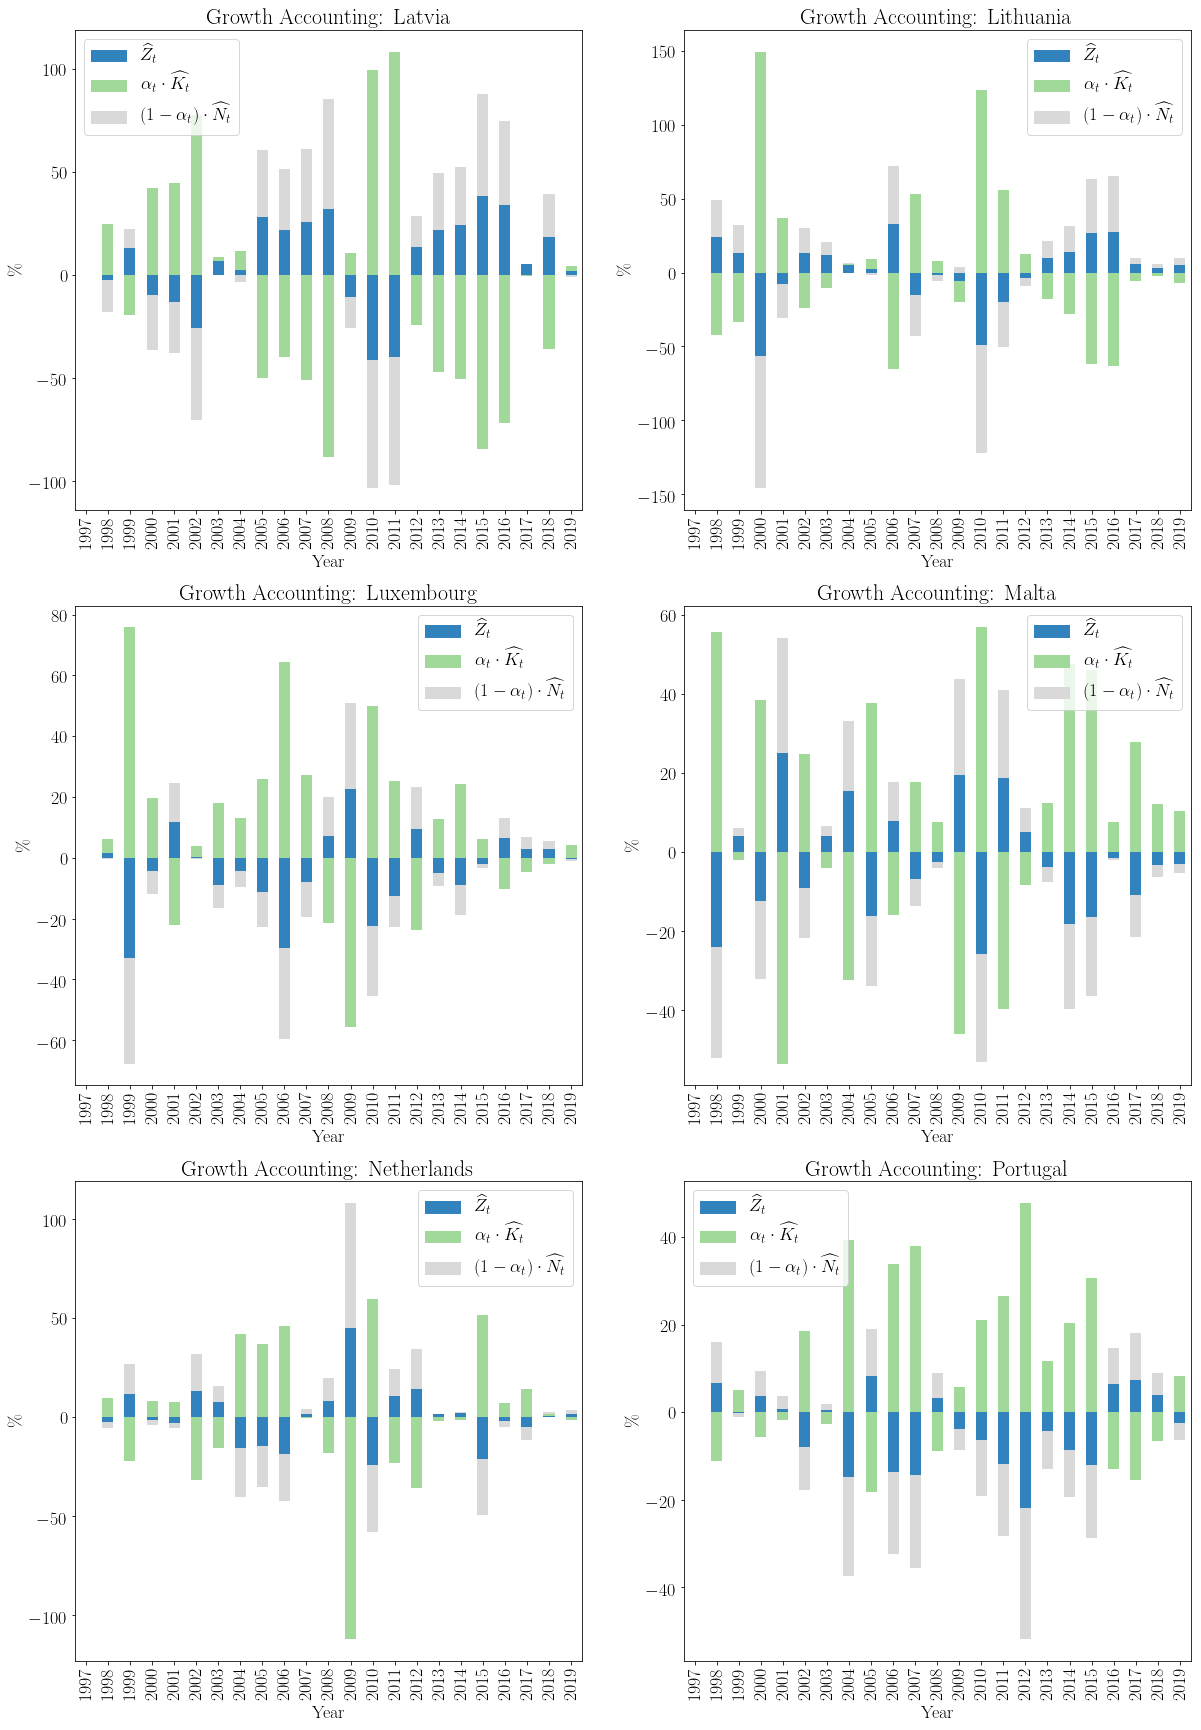

In [45]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 30)); axes = axes.flatten()
level = 10
for i in range(0,6):    
    df_temp = pd.DataFrame(index=range(1997, 2020)); #df_temp.index = pd.to_datetime(df_temp.index, format='%Y')
    df_temp["dZ"] = dZ[study_countries[i+level]]; df_temp["adK"] = adK[study_countries[i+level]]; df_temp["bdN"] = bdN[study_countries[i+level]] 
    df_temp.plot.bar(stacked=True, ax=axes[i], cmap=plt.cm.get_cmap('tab20c'))
    axes[i].legend(labels=[r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    axes[i].set_title("Growth Accounting: "+study_countries[i+level], fontsize=22)
    axes[i].set_ylabel("\%")
    axes[i].set_xlabel("Year")

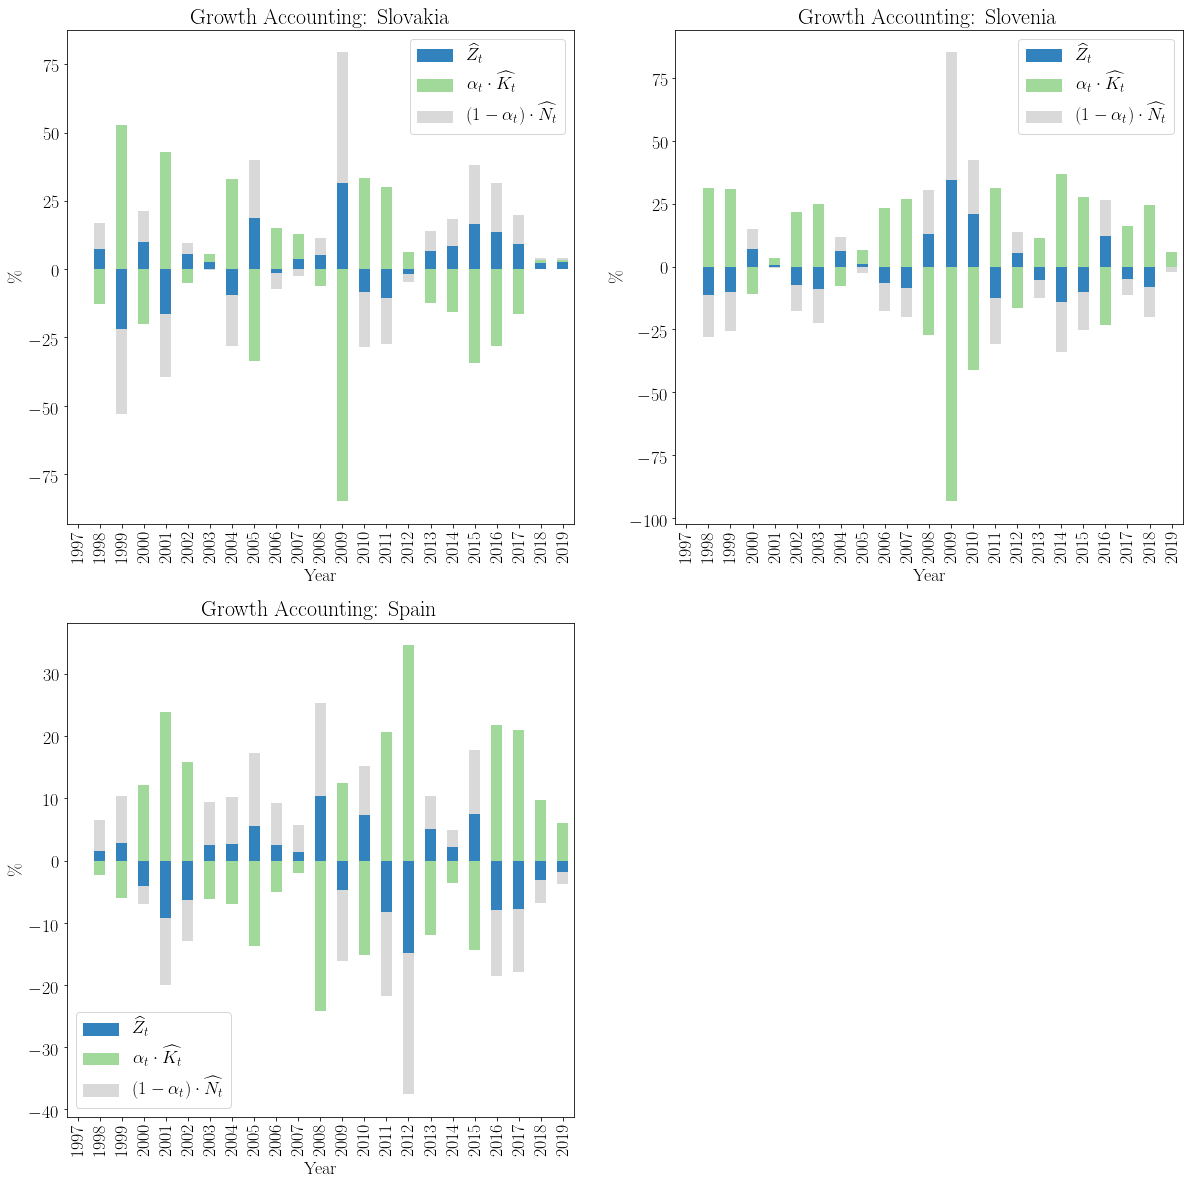

In [46]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20)); axes = axes.flatten(); f.delaxes(axes[3])
level = 16
for i in range(0,3):    
    df_temp = pd.DataFrame(index=range(1997, 2020)); #df_temp.index = pd.to_datetime(df_temp.index, format='%Y')
    df_temp["dZ"] = dZ[study_countries[i+level]]; df_temp["adK"] = adK[study_countries[i+level]]; df_temp["bdN"] = bdN[study_countries[i+level]] 
    df_temp.plot.bar(stacked=True, ax=axes[i], cmap=plt.cm.get_cmap('tab20c'))
    axes[i].legend(labels=[r"$ \widehat{Z_t}$", r"$\alpha_t \cdot \widehat{K_t}$", r"$(1-\alpha_t) \cdot \widehat{N_t}$"])
    axes[i].set_title("Growth Accounting: "+study_countries[i+level], fontsize=22)
    axes[i].set_ylabel("\%")
    axes[i].set_xlabel("Year")